###### Effective Field Theory

In [1]:
using Revise
using Plots
using Scattering
using ProgressBars
using LaTeXStrings
import PyPlot
using PyCall
const plt = PyPlot;
using DelimitedFiles
using DataFrames
using Statistics
using Optim
using LineSearches
using BlackBoxOptim
using LsqFit
#using LeastSquaresOptim
#pygui(true)
#%matplotlib inline

┌ Info: Precompiling Scattering [ee89e84f-d0c9-46d3-af34-50d21503c048]
└ @ Base loading.jl:1278


# Setup

## Global Variables and Helper Functions

In [2]:
raw = readdlm("../../project1/data/data.csv")
head, body = Symbol.(raw[1, :]), Float64.(raw[2:end, :])
data = DataFrame(body, head);
@show head;

head = [:T, :pwa93, :esc96, :nijm1, :nijm2, :nijm93]


In [3]:
# Reduced mass of n+p in lab frame in units [fm⁻¹]
mass = 2*(mₙ*mₚ)/(mₙ+mₚ) /197  

4.768621711440031

Create a function to do the book-keeping for RMatrix calculation and VPA calculation

In [4]:
function computerange(start, stop, length)::Vector{Float64}
    if stop < start 
        start = 0.1stop
    end
    stop /= 2
    start /= 2
    10 .^(range(log10(start), log10(stop), length=length))
end

function computephase(V::Potential; method::Scattering.Method=KMatrix(30),
         startpoint=1e-3, endpoint=3, length=50)
    # Logspaced points to introduce a bias in the error function
    # towards the low energy region
    E = computerange(startpoint, endpoint, length)
    k = .√(mass/197*E)
    δ = phaseshift(k, mass, V, method)
    2E, δ
end
computephase(V::Potential, m::Scattering.Method; kwargs...) = computephase(V; method=m, kwargs...)

computephase (generic function with 2 methods)

Compute an "exact" phase shift for comparison. This is used to construct a factory function which creates the error function and handles all of the book keeping of creating a potential, inserting the coefficients and computing the mean square error.

In [5]:
MSE(x, y) = mean((x.-y).^2)
# Using MSE doesn't make sense. Use χ²
# maybe relative error? Yes, relative error
χ²(fact, test) = @. (test - fact)^2/fact
Σχ²(fact, test) = sum(χ²(fact, test))
relerr(fact, test) = @. abs(test-fact)/fact
Σrelerr(fact, test) = sum(relerr(fact, test))

function makeerrorfunction(V::Type{<:Potential}; method::Scattering.Method=KMatrix(30), 
                           Λ=0.7, fact=nothing, kwargs...)
    E_fit, δReid_fit = computephase(Reid(); kwargs...);
    if isnothing(fact)
        fact = δReid_fit
    end
    function error(coeffs)::Float64
        W = regularize(V(coeffs...), Λ)
        _, δ = computephase(W, method; kwargs...)
        if δ[5] < 0
            return Inf
        end
        #Σχ²(fact, δ)
        Σrelerr(fact, δ)
    end
    return error
end
makeerrorfunction(V::Type{<:Potential}, method::Scattering.Method; kwargs...) = makeerrorfunction(V; method=method, kwargs...)

makeerrorfunction (generic function with 2 methods)

In [6]:
struct Params
    start::Float64
    stop::Float64
    length::Int64
    Λ::Vector{Float64}
end
Params(start, stop, length) = Params(start, stop, length, [0.7])
Params(start, stop) = Params(start, stop, 50)
Params(stop) = Params(1e-3, stop)

abstract type AbstractFitParams end

struct FitParams <: AbstractFitParams
    params::Params
    V::Type{<:Potential}
    minlim::Vector{Float64}
    maxlim::Vector{Float64}
    C₀::Vector{Float64}
    method::Symbol
    methodkws::Any
    kwargs::Any
end
function FitParams(params, V::Type{<:Potential}, minlim::Vector{<:Real}, maxlim::Vector{<:Real}, C₀::Vector{<:Real};
        method=:LBFGS, methodkws=Dict(), kwargs...)
   FitParams(params, V, minlim, maxlim, C₀, method, methodkws, kwargs) 
end
function FitParams(params, V::Type{<:Potential}, minlim::Real, maxlim::Real; kwargs...)
    FitParams(params, V, [minlim], [maxlim], Float64[]; kwargs...)
end
function FitParams(params, V::Type{<:Potential}; C₀, kwargs...) 
    minlim = fill(-Inf, length(C₀))
    maxlim = fill(Inf, length(C₀))
    FitParams(params, V, minlim, maxlim, C₀; kwargs...)
end
FitParams(params, V::Type{<:Potential}, minlim::Nothing, maxlim::Nothing; kwargs...) = FitParams(params, V; kwargs...)

struct FitResult
    params::AbstractFitParams
    res::Any
    C::Vector{Float64}
end
FitResult(p::AbstractFitParams, res, C::Float64) = FitResult(p, res, [C])

FitResult

In [7]:
struct FitParamsPion <: AbstractFitParams
    params::Params
    V::Type{<:Potential}
    minlim::Vector{Float64}
    maxlim::Vector{Float64}
    C₀::Vector{Float64}
    Cπ::Vector{Float64}
    method::Symbol
    methodkws::Any
    kwargs::Any
end
function FitParamsPion(p::Params, V::Type{<:Potential}, C₀, Cpi::Vector{<:Real};
        method=:LsqFit, methodkws=Dict(), minlim=nothing, maxlim=nothing, kwargs...)
    if isnothing(minlim)
        minlim = fill(-Inf, length(C₀) + length(Cpi))
    end
    if isnothing(maxlim)
        maxlim = fill(Inf, length(C₀) + length(Cpi))
    end
    FitParamsPion(p, V, minlim, maxlim, C₀, Cpi, method, methodkws, kwargs)
end

FitParamsPion

In [8]:
import Base.error

function fit(fparams::AbstractFitParams)
    solver = makesolver(fparams)
    res = solver()
    C = getsol(fparams, res)
    FitResult(fparams, res, C)
end

function getsol(fparams::AbstractFitParams, res)
    if fparams.method == :DE
        best_candidate(res)
    elseif fparams.method == :LsqFit
        res.param
    else
        Optim.minimizer(res)
    end
end

function makesolver(fparams::AbstractFitParams)
    V = fparams.V
    startpoint = fparams.params.start
    endpoint = fparams.params.stop
    length_ = fparams.params.length
    Λ = getΛ(fparams)
    _, reid = reidphase(fparams)
    erf = makeerrorfunction(V; startpoint, endpoint, length=length_, Λ, fact=reid)
    minlim = fparams.minlim
    maxlim = fparams.maxlim
    p₀ = getC₀(fparams)
    if length(minlim) == 1 && fparams.method ∉ Set([:LsqFit])
        () -> optimize(erf, minlim[1], maxlim[1])
    else
        if fparams.method in Set([:LBFGS, :GradientDescent])
            if fparams.method == :LBFGS
                inner = LBFGS(;fparams.methodkws...)
            elseif fparams.method == :GradientDescent
                inner = GradientDescent(;fparams.methodkws...)
            end
            () -> optimize(erf, minlim, maxlim, p₀, 
                           Fminbox(inner), Optim.Options(;fparams.kwargs...))
        elseif fparams.method == :Annealing
            () -> optimize(erf, minlim, maxlim, p₀, 
                           SAMIN(;fparams.methodkws...), Optim.Options(;fparams.kwargs...))
        elseif fparams.method == :ParticleSwarm
            () -> optimize(erf, minlim, maxlim, p₀,
                            ParticleSwarm(;fparams.methodkws...),
                            Optim.Options(;fparams.kwargs...))
        elseif fparams.method == :DE
            () -> bboptimize(erf; SearchRange = zip(minlim, maxlim) |> collect
                            ,fparams.kwargs...)
        elseif fparams.method == :LSOpt
            () -> LeastSquaresOptim.optimize(erf, p₀, LeastSquaresOptim.Dogleg();
                                             fparams.kwargs...)
        elseif fparams.method == :LsqFit
            X = computerange(fparams)
            E, reid = reidphase(fparams)
            function model(x, p)
                k = .√(mass/197*(x))
                W = makeV(fparams, p)
                δ = phaseshift(k, mass, W, KMatrix(30))
            end
            () -> curve_fit(model, X, reid, p₀, lower=minlim, upper=maxlim)
        else
            throw(error(""))
        end
    end
end

computerange(p::AbstractFitParams) = computerange(p.params)
computerange(p::Params) = computerange(p.start, p.stop, p.length)

function makeV(f::FitParams, C)
    V = f.V(C...) |> x -> regularize(x, getΛ(f))
end
function makeV(f::FitParamsPion, C)
    n = length(f.C₀)
    V = f.V(C[1:n]...) + Pion(C[(n+1):end]...) |> x -> regularize(x, getΛ(f)) 
end
makeV(f::FitResult) = makeV(f.params, f.C)
getC₀(f::FitParams) = f.C₀
getC₀(f::FitParamsPion) = [f.C₀..., f.Cπ...]
    

function phase(V::Type{<:Potential}, coefficients, p::Params)
    V_ = V(coefficients...) |> x -> regularize(x, getΛ(p))
    E, δ = computephase(V_; startpoint=p.start,
    endpoint=p.stop, length=p.length)
end

function phase(V::Potential, p::Params)
    E, δ = computephase(V; startpoint=p.start,
    endpoint=p.stop, length=p.length)
end
function phase(coefficients, fparams::AbstractFitParams)
    V = makeV(fparams, coefficients)
    phase(V, fparams.params)
end

function phase(res::FitResult)
    phase(res.C, res.params)
end

function phase(res::FitResult, start, stop; length=350)
    V = makeV(res)
    E, δ = computephase(V; startpoint=start, endpoint=stop, length=length)
end

function reidphase(params::Params)
    E, δ = computephase(Reid(); startpoint=params.start, endpoint=params.stop,
        length=params.length) 
end

function reidphase(start, stop; length=350)
    E, δ = computephase(Reid(); startpoint=start, endpoint=stop,
        length=length) 
end
reidphase(p::AbstractFitParams) = reidphase(p.params)
reidphase(res::FitResult) = reidphase(res.params)


getΛ(p::Params) = p.Λ[1]
getΛ(p::AbstractFitParams) = getΛ(p.params)
getΛ(res::FitResult) = getΛ(res.params)

function error(res::FitResult, start, stop; length=350)
    _, δ = phase(res, start, stop; length)
    E, δreid = reidphase(start, stop; length)
    E, relerr(δreid, δ)
end

function error(res::FitResult)
    _, δ = phase(res)
    E, δreid = reidphase(res)
    E, relerr(δreid, δ)
end

error (generic function with 5 methods)

## Plotting

In [9]:
function savefig(fig, name; dpi=196, kwargs...)
    path = joinpath("../latex/Figures/", name)
    fig.savefig(path, dpi=dpi, bbox_inches="tight", kwargs...)
end

function cmap(name, number)
    cm = plt.cm.get_cmap(name)
    Ncolors = min(cm.N, number)
    mapcolors = [cm(round(Int, x*cm.N/Ncolors)) for x in 1:Ncolors]
end
++(a, b) = append!(collect(a), collect(b))

++ (generic function with 1 method)

In [10]:
function newfig(;mul=1, height=nothing, kwargs...)
    fig_width_pt = 467.42 # Get this from LaTeX using \showthe\columnwidth
    inches_per_pt = 1.0/72.27               # Convert pt to inches
    golden_mean = (sqrt(5)-1.0)/2.0         # Aesthetic ratio
    fig_width = fig_width_pt*inches_per_pt  # width in inches
    fig_height =fig_width*golden_mean       # height in inches
    if height != nothing
       fig_height *= height 
    end
    nrows = get(kwargs, :nrows, 1)
    fig_size = mul*[fig_width,nrows*fig_height] 
    plt.subplots(figsize=(fig_size); kwargs...)
end


newfig (generic function with 1 method)

In [11]:
function updaterc()
    rcParams = PyPlot.PyDict(PyPlot.matplotlib."rcParams")
    basesize = 12
    rcParams["backend"] = "ps"
    #rcParams["font.family"] = 
    rcParams["font.size"] = basesize
    rcParams["axes.labelsize"] = basesize
    rcParams["legend.fontsize"] = basesize
    rcParams["xtick.labelsize"] = basesize-2
    rcParams["ytick.labelsize"] = basesize-2
    rcParams["text.usetex"] = true
    rcParams["text.color"] = "252525"
    rcParams["xtick.major.size"] = 3
    rcParams["ytick.major.size"] = 3
    rcParams["xtick.minor.size"] = 1
    rcParams["hatch.linewidth"] = 0.1  # previous pdf hatch linewidth 
end
plt.matplotlib.style.use("rapport")
@show plt.matplotlib.style.available
updaterc()

matplotlib = pyimport("matplotlib")

function pi_ticks(ax;base=0.5)
    ticker = matplotlib.ticker.FormatStrFormatter(raw"$%g \: \pi$")
    locator = matplotlib.ticker.MultipleLocator(base=base)
    ax.set_major_formatter(ticker)
    ax.set_major_locator(locator)
end

function twinscale(ax; func=x -> x*197)
    ax2 = ax.twiny()
    function convert_ax(ax_f)
        """
        Update second axis according with first axis.
        """
        y1, y2 = ax_f.get_xlim()
        ax2.set_xlim(func(y1), func(y2))
        ax2.figure.canvas.draw()
    end
    ax.callbacks.connect("xlim_changed", convert_ax)
    return ax2
end

plt.matplotlib.style.available = ["Solarize_Light2", "_classic_test_patch", "bmh", "classic", "dark_background", "fast", "fivethirtyeight", "ggplot", "grayscale", "rapport", "seaborn", "seaborn-bright", "seaborn-colorblind", "seaborn-dark", "seaborn-dark-palette", "seaborn-darkgrid", "seaborn-deep", "seaborn-muted", "seaborn-notebook", "seaborn-paper", "seaborn-pastel", "seaborn-poster", "seaborn-talk", "seaborn-ticks", "seaborn-white", "seaborn-whitegrid", "tableau-colorblind10"]


twinscale (generic function with 1 method)

In [56]:
label(f::FitResult) = label(f.params.V)
label(::Type{LO}) = "LO"
label(::Type{NLO}) = "NLO"
label(::Type{NNLO}) = "NNLO"
label(::Type{Reid}) = "Reid"
getlabel = label

function plotphase(res::Vector{FitResult}, start, stop; length=350, ax=nothing,
    legend=true)
    if isnothing(ax)
        fig, ax = newfig()
    end
    E, δReid = reidphase(start, stop; length)
    
    ax.plot(E, δReid, label="Reid", linestyle="--", c="k", zorder=10)
    for r in res
        E, δ = phase(r, start, stop; length)
        ax.plot(E, δ, label=label(r))
    end
    ax.set_xlim(start, stop)
    ax.axhline(y=0, c="k", linewidth=1, alpha=0.5)
    ax.set_xlabel(L"$T_{\mathrm{Lab}}$ [MeV]")
    ax.set_ylabel(L"$\delta_0$ [deg]")
    ax.set_xscale("log")
    legend && ax.legend()
    plotfitregion(res[1], ax)
    ax
end

function plotphase(res::FitResult, start, stop; length=350, ax=nothing, label=nothing)
   if isnothing(ax)
        fig, ax = newfig()
    end
    if isnothing(label)
        label = getlabel(res)
    end
    E, d = phase(res, start, stop; length)
    ax.plot(E, d, label=label)
    ax
end
function ploterror(res::FitResult, start, stop; length=350, ax=nothing, label=nothing)
   if isnothing(ax)
        fig, ax = newfig()
    end
    if isnothing(label)
        label = getlabel(res)
    end
    E, d = error(res, start, stop)
    ax.plot(E, d, label=label)
    ax
end
function ploterror(res::Vector{FitResult}, start, stop; length=350, ax=nothing,
    legend=true, region=true)
    if isnothing(ax)
        fig, ax = newfig()
    end
   
    for r in res
        E, Δδ = error(r, start, stop)
        ax.plot(E, Δδ, label=label(r))
    end
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(L"$T_{\mathrm{Lab}}$ [MeV]")
    ax.set_ylabel("Relative error")
    legend && ax.legend()
    region && plotfitregion(res[1], ax)
    ax
end

function plotdiff(res::Vector{FitResult}, start, stop; length=350, ax=nothing,
    legend=true)
    if isnothing(ax)
        fig, ax = newfig()
    end
   
    E, δReid = reidphase(start, stop; length)
    for r in res
        E, δ = phase(r, start, stop; length)
        diff = δReid .- δ
        ax.plot(E, diff, label=label(r))
    end
    ax.axhline(y=0, c="k", linewidth=1, alpha=0.5)
    ax.set_xscale("log")
    ax.set_yscale("log")
    ax.set_xlabel(L"$T_{\mathrm{Lab}}$ [MeV]")
    ax.set_ylabel("Difference in phase shift [deg]")
    legend && ax.legend()
    plotfitregion(res[1], ax)
    ax
end
    


function plotfitregion(res::FitResult, ax)
   E = 2computerange(res.params.params.start, res.params.params.stop,
        res.params.params.length)
    m = []
    for line in ax.lines
        data = line._yorig
        push!(m, minimum(data))
    end
    offset = minimum(m)
    ax.plot(E, offset * ones(length(E)), "|", color="grey")
end

plotfitregion (generic function with 1 method)

# Pionless Interactions

## Comparisons by region

### Low energy

In [25]:
p = Params(1e-2)
fp = FitParams(p, LO, -1, 1)
fp = FitParams(p, LO, [-1], [1], [0.0], method=:LsqFit)
resLO = fit(fp)
fp = FitParams(p, NLO, [-1, -1], [1, 1], [-0.537, 0.03];
                method=:LBFGS,
                time_limit=60*4, iterations=1e6 |> Int, 
                methodkws=Dict(:alphaguess => LineSearches.InitialHagerZhang(α0=1.0)),
                show_trace=true)
fp = FitParams(p, NLO, [-2, -2], [2, 2], [-0.5, 0.0];
                method=:ParticleSwarm,
                time_limit=60*10, iterations=1e6 |> Int, 
                methodkws=Dict(:n_particles=>100),
                show_trace=true)
fp = FitParams(p, NLO, [-2, -2], [2, 2], [-0.5, 0.0];
                method=:DE,
                MaxTime=60*10, TraceMode=:verbose)
fp = FitParams(p, NLO, [-2, -2], [2, 2], [-0.5, 0.0];
                method=:LsqFit)
resNLO = fit(fp)

@show confidence_interval(resLO.res, 0.05)
@show confidence_interval(resNLO.res, 0.05)

confidence_interval(resLO.res, 0.05) = [(-0.5308986920495616, -0.5308969327628409)]
confidence_interval(resNLO.res, 0.05) = [(-0.5405166918211033, -0.5405053693902926), (0.048009477868465954, 0.04806646038726608)]


2-element Array{Tuple{Float64,Float64},1}:
 (-0.5405166918211033, -0.5405053693902926)
 (0.048009477868465954, 0.04806646038726608)

In [39]:

fp = FitParams(p, NNLO, [-1, -1, -2, -2], [1, 1, 1, 1], [-0.5, 0.0, 0.0, 0.0];
                method=:GradientDescent,linesearch=LineSearches.BackTracking,
                g_tol=1e-12, time_limit=60*5)

fp = FitParams(p, NNLO, [-1, -1, -2, -2], [1, 1, 1, 1], [-0.5, 0.0, 0.0, 0.0];
                method=:ParticleSwarm,
                time_limit=60*4, iterations=1e6 |> Int, 
                methodkws=Dict(:n_particles=>3),
                show_trace=true)
fp = FitParams(p, NNLO, [-1, -1, -2, -2], [1, 1, 1, 1], [-0.5, 0.0, 0.0, 0.0];
                method=:DE,
                MaxTime=60*10, TraceMode=:compact)
fp = FitParams(p, NNLO,# [-1, -1, -2, -3], [1, 1, 1, 1], [-0.5, 0.4, -0.9, -3];
                C₀ = [-0.5, -0.03, -1.1, -1.8],
                method=:LsqFit)
resNNLO = fit(fp)
@show confidence_interval(resNNLO.res, 0.05)

confidence_interval(resNNLO.res, 0.05) = [(-18.29390430051726, 17.30032465352532), (-36.748362601930424, 36.85743801767481), (-281.9261257963367, 279.95136019975655), (-596.1712492914369, 597.9208705899357)]


4-element Array{Tuple{Float64,Float64},1}:
 (-18.29390430051726, 17.30032465352532)
 (-36.748362601930424, 36.85743801767481)
 (-281.9261257963367, 279.95136019975655)
 (-596.1712492914369, 597.9208705899357)

In [47]:
fp = FitParams(p, NNLO,[-1, -1, -2, -3], [1, 1, 1, 1], [-0.5, 0.4, -0.9, -3];
                method=:LsqFit)
resNNLO_const = fit(fp)

FitResult(FitParams(Params(0.001, 0.01, 50, [0.7]), NNLO, [-1.0, -1.0, -2.0, -3.0], [1.0, 1.0, 1.0, 1.0], [-0.5, 0.4, -0.9, -3.0], :LsqFit, Dict{Any,Any}(), Base.Iterators.Pairs{Union{},Union{},Tuple{},NamedTuple{(),Tuple{}}}()), LsqFit.LsqFitResult{Array{Float64,1},Array{Float64,1},Array{Float64,2},Array{Float64,1}}([-0.5222473152315251, 0.3744603883897826, -1.1831263322490724, -1.8514134830731268], [-2.1084850310160164e-7, -2.0856266225166564e-7, -2.063180768452355e-7, -2.0358942842690908e-7, -2.0021941127268406e-7, -1.9603490386543854e-7, -1.9167940124020788e-7, -1.8652801614393866e-7, -1.8047431638024136e-7, -1.7404942287413405e-7  …  2.3770115475940656e-7, 2.1515159254192895e-7, 1.816082981775935e-7, 1.350630220997573e-7, 7.314523209345225e-8, -6.9202990005123866e-9, -1.0799585936638323e-7, -2.3365540258168949e-7, -3.878125767187157e-7, -5.75006930958466e-7], [-50.73076466151129 -11.170035720077149 -3.1327552913302688 -0.6148621030483719; -51.92553459108583 -11.433166831729316 -3.

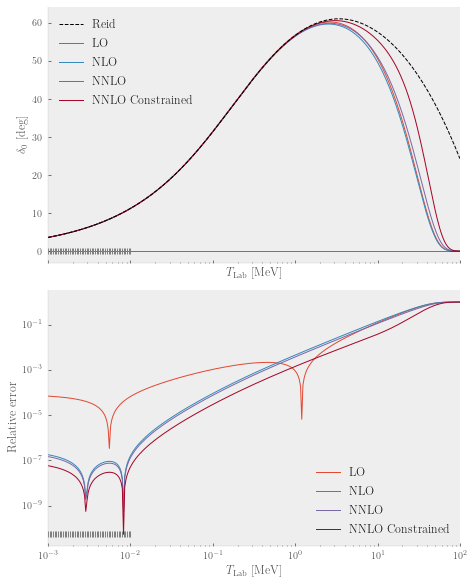

In [59]:
fig, ax = newfig(nrows=2, sharex=true, constrained_layout=true)
plotphase([resLO, resNLO, resNNLO], 1e-3, 1e2; ax=ax[1])
ploterror([resLO, resNLO, resNNLO], 1e-3, 1e2; ax=ax[2], region=false)
plotphase(resNNLO_const, 1e-3, 1e2; ax=ax[1], label="NNLO Constrained")
ploterror(resNNLO_const, 1e-3, 1e2; ax=ax[2], label="NNLO Constrained")
plotfitregion(resNNLO_const, ax[2])
ax[1].legend()
ax[2].legend()
savefig(fig, "lowenergy.pdf")

In [62]:
function ci(res)
    co = res.C
    println(res.params.V)
    cis = confidence_interval(res.res, 0.05)
    for (c, (l, h)) in zip(co, cis)
        @show c
        @show h-l
    end
    println()
end
map(ci, [resLO, resNLO, resNNLO, resNNLO_const])
#@show Optim.minimum(resLO.res)
#@show Optim.minimum(resNLO.res)
#@show Optim.minimum(resNNLO.res)
@show resNNLO.C
@show resNNLO.params.minlim
@show resNNLO.params.maxlim
@show resNNLO.params.C₀

LO
c = -0.5308978124062013
h - l = 1.759286720748321e-6

NLO
c = -0.5405110306056979
h - l = 1.1322430810700723e-5
c = 0.048037969127866016
h - l = 5.698251880012495e-5

NNLO
c = -0.49678982349596884
h - l = 35.59422895404258
c = 0.0545377078721908
h - l = 73.60580061960523
c = -0.9873827982900771
h - l = 561.8774859960932
c = 0.874810649249459
h - l = 1194.0921198813726

NNLO
c = -0.5222473152315251
h - l = 25.82242393795822
c = 0.3744603883897826
h - l = 40.696067605123076
c = -1.1831263322490724
h - l = 445.271041707325
c = -1.8514134830731268
h - l = 877.4471352357882

resNNLO.C = [-0.49678982349596884, 0.0545377078721908, -0.9873827982900771, 0.874810649249459]
resNNLO.params.minlim = [-Inf, -Inf, -Inf, -Inf]
resNNLO.params.maxlim = [Inf, Inf, Inf, Inf]
resNNLO.params.C₀ = [-0.5, -0.03, -1.1, -1.8]


4-element Array{Float64,1}:
 -0.5
 -0.03
 -1.1
 -1.8

### Mid energy

In [63]:
p = Params(1)
fp = FitParams(p, LO, [-1], [1], [0.0], method=:LsqFit)
resLO = fit(fp)

fp = FitParams(p, NLO, [-2, -2], [2, 2], [-0.5, 0.0];
                method=:LsqFit)
resNLO = fit(fp)
@show confidence_interval(resLO.res, 0.05)
@show confidence_interval(resNLO.res, 0.05)

confidence_interval(resLO.res, 0.05) = [(-0.5307685979025001, -0.5307042559449087)]
confidence_interval(resNLO.res, 0.05) = [(-0.5344746303626607, -0.533144871843893), (0.011633031876433352, 0.018069762143867813)]


2-element Array{Tuple{Float64,Float64},1}:
 (-0.5344746303626607, -0.533144871843893)
 (0.011633031876433352, 0.018069762143867813)

In [64]:
fp = FitParams(p, NNLO, [-1, -1, -2, -3], [1, 1, 1, 1], [-0.5, 0.4, -0.9, -3];
                method=:LsqFit)
fp = FitParams(p, NNLO, [-Inf, -Inf, -Inf, -Inf], [Inf, Inf, Inf, Inf], [-0.5, 0.4, -0.9, -3];
                method=:LsqFit)
resNNLO = fit(fp)
println(resNNLO.C)
println(confidence_interval(resNNLO.res, 0.05))

[-0.4677534171930523, 0.44263372087769637, -2.3688803215367673, -1.1323606000590434]
[(-0.6562057072948249, -0.2793011270912797), (0.13234580359949127, 0.7529216381559014), (-5.012951163641267, 0.2751905205677323), (-6.553918493342124, 4.289197293224037)]


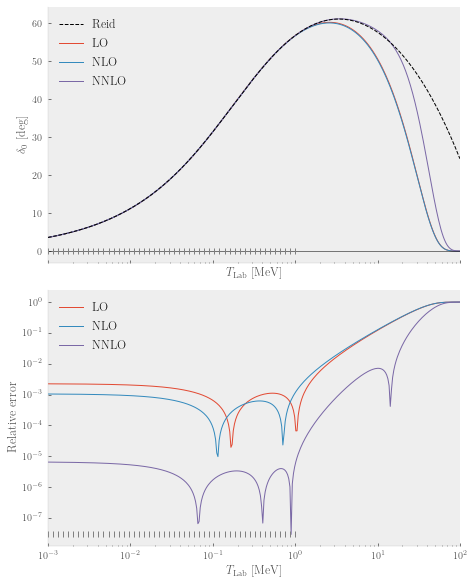

In [65]:
fig, ax = newfig(nrows=2, sharex=true, constrained_layout=true)
plotphase([resLO, resNLO, resNNLO], 1e-3, 1e2; ax=ax[1])
ploterror([resLO, resNLO, resNNLO], 1e-3, 1e2; ax=ax[2])
savefig(fig, "midenergy.pdf")

In [66]:
function ci(res)
    co = res.C
    println(res.params.V)
    cis = confidence_interval(res.res, 0.05)
    for (c, (l, h)) in zip(co, cis)
        @show c
        @show h-l
    end
    println()
end
map(ci, [resLO, resNLO, resNNLO])
#@show Optim.minimum(resLO.res)
#@show Optim.minimum(resNLO.res)
#@show Optim.minimum(resNNLO.res)
@show resNNLO.C
@show resNNLO.params.minlim
@show resNNLO.params.maxlim
@show resNNLO.params.C₀

LO
c = -0.5307364269237044
h - l = 6.434195759141836e-5

NLO
c = -0.5338097511032769
h - l = 0.0013297585187677097
c = 0.014851397010150582
h - l = 0.006436730267434462

NNLO
c = -0.4677534171930523
h - l = 0.37690458020354517
c = 0.44263372087769637
h - l = 0.6205758345564101
c = -2.3688803215367673
h - l = 5.288141684208999
c = -1.1323606000590434
h - l = 10.84311578656616

resNNLO.C = [-0.4677534171930523, 0.44263372087769637, -2.3688803215367673, -1.1323606000590434]
resNNLO.params.minlim = [-Inf, -Inf, -Inf, -Inf]
resNNLO.params.maxlim = [Inf, Inf, Inf, Inf]
resNNLO.params.C₀ = [-0.5, 0.4, -0.9, -3.0]


4-element Array{Float64,1}:
 -0.5
  0.4
 -0.9
 -3.0

### High energy

In [67]:
p = Params(1e2)
fp = FitParams(p, LO, [-1], [1], [0.0], method=:LsqFit)
resLO = fit(fp)

fp = FitParams(p, NLO, [-2, -2], [2, 2], [-0.5, 0.0];
                method=:LsqFit)
resNLO = fit(fp)
@show confidence_interval(resLO.res, 0.05)
@show confidence_interval(resNLO.res, 0.05)

confidence_interval(resLO.res, 0.05) = [(-0.5492499534703309, -0.5180913362501219)]
confidence_interval(resNLO.res, 0.05) = [(-0.4775726514148069, -0.3181245767113105), (-0.8909326446386672, -0.26211657054770443)]


2-element Array{Tuple{Float64,Float64},1}:
 (-0.4775726514148069, -0.3181245767113105)
 (-0.8909326446386672, -0.26211657054770443)

In [68]:
fp = FitParams(p, NNLO, [-1, -1, -2, -3], [1, 1, 1, 1], [-0.5, 0.4, -0.9, -3];
                method=:LsqFit)
fp = FitParams(p, NNLO, [-Inf, -Inf, -Inf, -Inf], [Inf, Inf, Inf, Inf], [-0.5, 0.4, -0.9, -3];
                method=:LsqFit)
resNNLO = fit(fp)
println(resNNLO.C)
@show confidence_interval(resNNLO.res, 0.05)

[-0.6954995375136857, 1.301504347517411, -2.988602340937581e-7, -9.590527191543789]
confidence_interval(resNNLO.res, 0.05) = [(-1.186693376999519e6, 1.186691986000444e6), (-1.632408789151243e6, 1.6324113921599379e6), (-5.122989939863317e7, 5.122989939863257e7), (-7.998648536271761e7, 7.998646618166323e7)]


4-element Array{Tuple{Float64,Float64},1}:
 (-1.186693376999519e6, 1.186691986000444e6)
 (-1.632408789151243e6, 1.6324113921599379e6)
 (-5.122989939863317e7, 5.122989939863257e7)
 (-7.998648536271761e7, 7.998646618166323e7)

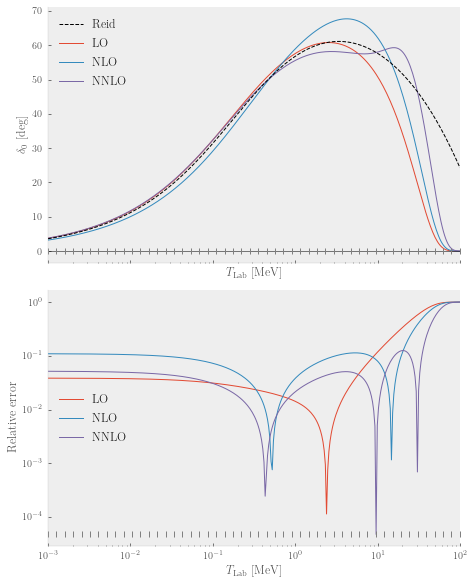

In [71]:
fig, ax = newfig(nrows=2, sharex=true, constrained_layout=true)
plotphase([resLO, resNLO, resNNLO], 1e-3, 1e2; ax=ax[1])
ploterror([resLO, resNLO, resNNLO], 1e-3, 1e2; ax=ax[2])
savefig(fig, "highenergy.pdf")
#E, d = computephase(regularize(NLO(-0.59, 1.06), 1.2), startpoint=1e-3, endpoint=1e2, length=350)
#ax[1].plot(2E, d)
#plotdiff([resLO, resNLO, resNNLO], 1e-3, 1e2; ax=ax[2])
#ax[2].set_xscale("linear")
#ax[2].set_yscale("linear")

In [70]:
function ci(res)
    co = res.C
    println(res.params.V)
    cis = confidence_interval(res.res, 0.05)
    for (c, (l, h)) in zip(co, cis)
        @show c
        @show h-l
    end
    println()
end
map(ci, [resLO, resNLO, resNNLO])
#@show Optim.minimum(resLO.res)
#@show Optim.minimum(resNLO.res)
#@show Optim.minimum(resNNLO.res)
@show resNNLO.C
@show resNNLO.params.minlim
@show resNNLO.params.maxlim
@show resNNLO.params.C₀

LO
c = -0.5336706448602264
h - l = 0.031158617220208962

NLO
c = -0.3978486140630587
h - l = 0.15944807470349642
c = -0.5765246075931858
h - l = 0.6288160740909627

NNLO
c = -0.6954995375136857
h - l = 2.373385362999963e6
c = 1.301504347517411
h - l = 3.264820181311181e6
c = -2.988602340937581e-7
h - l = 1.0245979879726574e8
c = -9.590527191543789
h - l = 1.5997295154438084e8

resNNLO.C = [-0.6954995375136857, 1.301504347517411, -2.988602340937581e-7, -9.590527191543789]
resNNLO.params.minlim = [-Inf, -Inf, -Inf, -Inf]
resNNLO.params.maxlim = [Inf, Inf, Inf, Inf]
resNNLO.params.C₀ = [-0.5, 0.4, -0.9, -3.0]


4-element Array{Float64,1}:
 -0.5
  0.4
 -0.9
 -3.0

## Find influence on number of fit points

In [70]:
function measuretime(V, coeffs, numpoints; minlim=nothing, maxlim=nothing)
    n = length(coeffs)
    minlim = if isnothing(minlim) fill(-1.0, 2) else minlim end
    maxlim = if isnothing(maxlim) fill(1.0, 2) else maxlim end
    time = Float64[]
    errors = Vector{Float64}[]
    coefficients = Vector{Float64}[]
    full_length = max(100, maximum(numpoints))
    curves = Vector{Float64}[]
    E, reid_full = computephase(Reid(), length=full_length)
    for n in numpoints
        println(n)
        _, reid = computephase(Reid(), length=n)
        erf = makeerrorfunction(V, length=n, fact=reid)
        results = optimize(erf, minlim, maxlim, coeffs, Fminbox(), Optim.Options(time_limit=60.0*4))
        cres = Optim.minimizer(results)
        push!(time, results.time_run)
        push!(coefficients, cres)
        Vfit = V(cres...)
        Vfit = regularize(Vfit, 0.7)
        _, deltas = computephase(Vfit, length=full_length)
        error = @. (reid_full - deltas)/reid_full
        push!(errors, error)
        push!(curves, deltas)
    end
    E, errors, time, coefficients, curves
end

measuretime (generic function with 1 method)

In [71]:
points = [3, 5, 10, 15, 20, 50, 70, 80, 90, 100, 125, 150, 175, 200]
E, errors, time, coefficients, curves = measuretime(NLO, [-0.5, -0.1], points);

LoadError: InterruptException:

In [72]:
E, reid = computephase(Reid(), endpoint=20, length=350)
Vs = []
for coef in coefficients
    _, V = computephase(regularize(NLO(coef...), 0.7), endpoint=20, length=350)
    push!(Vs, V)
end

LoadError: UndefVarError: coefficients not defined

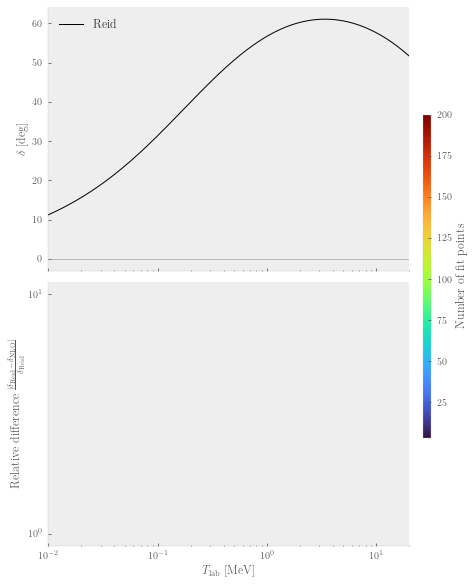

In [73]:
fig, (ax1, ax2) = newfig(nrows=2, constrained_layout=true, sharex=true)
cmap_ = "turbo"
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=plt.matplotlib.pyplot.Normalize(vmin=minimum(points), vmax=maximum(points)))
cm = cmap(cmap_, length(Vs))
ax1.axhline(y=0, c="gray", linewidth=0.5)
for (i, (point, phase)) in zip(points, Vs) |> enumerate
    ax1.plot(E, phase, color=cm[i])
    err = @. abs(reid-phase)/reid
    ax2.plot(E, err, color=cm[i])
end
ax1.plot(E, reid, color="k", label="Reid")
cbar = fig.colorbar(sm, ax=(ax1, ax2), shrink=0.6)#, location="right")
cbar.ax.set_ylabel("Number of fit points")
ax1.set_xscale("log")
ax2.set_yscale("log")
ax1.set_ylabel(L"$\delta$ [deg]")
ax2.set_ylabel(L"Relative difference $\frac{|\delta_{\mathrm{Reid}} - \delta_{\mathrm{NLO}}|}{\delta_{\mathrm{Reid}}}$")
ax1.legend()
ax1.set_xlim(1e-2, 20)
ax2.set_xlabel(L"$T_{\mathrm{lab}}$ [MeV]")
savefig(fig, "NLO_points_error.pdf")

In [74]:
fig, ax = newfig(nrows=2, sharex=true, tight_layout=true)
summed = map(x -> abs.(x) |> sum, errors)
summed ./= summed[end]
summed .-= 1
summed *= 100
ax[2].plot(points, summed)
ax[2].set_xlabel("Number of fit points")
ax[2].set_ylabel(L"Error relative to last point [$ \% $]")
ax[1].plot(points, time)
ax[1].set_ylabel("Optimization time [s]")
savefig(fig, "NLO_dependence_time_error.pdf")

LoadError: UndefVarError: errors not defined

In [75]:
fig, ax = newfig(nrows=2, sharex=true, tight_layout=true)
c0, c1 = zip(coefficients...)
ax[1].scatter(points, c0, zorder=100)
ax[2].scatter(points, c1, zorder=100)
ax[end].set_xlabel("Number of fit points")
ax[1].set_ylabel(L"C_0")
ax[2].set_ylabel(L"C_2")

x = range(-10, 250, length=10)
ax[1].fill_between(x, fill((1-10/100)c0[end], length(x)),
    fill((1-1/100)c0[end], length(x)), alpha=0.1,
                  label=L"10\%")
ax[1].fill_between(x, fill((1+10/100)c0[end], length(x)),
    fill((1+1/100)c0[end], length(x)), alpha=0.1, facecolor="C1")
ax[1].fill_between(x, fill((1+1/100)c0[end], length(x)),
    fill((1-1/100)c0[end], length(x)), alpha=0.1, facecolor="C0",
                  label=L"1\%", zorder=100)
ax[1].legend(loc="upper right")
#ax[2].axhline((1+percent/100)c1[end], label=L"10\%")
#ax[2].axhline((1-percent/100)c1[end])
percent=10
#ax[2].axhline((1+percent/100)c1[end], color="C2", label=L"1\%")
#ax[2].axhline((1-percent/100)c1[end], color="C2")
x = range(-10, 250, length=10)
ax[2].fill_between(x, fill((1-percent/100)c1[end], length(x)),
    fill((1-1/100)c1[end], length(x)), alpha=0.1,
                  label=L"10\%")
ax[2].fill_between(x, fill((1+percent/100)c1[end], length(x)),
    fill((1+1/100)c1[end], length(x)), alpha=0.1, facecolor="C1")
percent=1
ax[2].fill_between(x, fill((1+percent/100)c1[end], length(x)),
    fill((1-percent/100)c1[end], length(x)), alpha=0.1, facecolor="C0",
                  label=L"1\%", zorder=100)
ax[2].set_xlim(0, 200)
ax[2].legend(loc="right")
savefig(fig, "NLO_coeff_dependence.pdf")

LoadError: UndefVarError: coefficients not defined

## Dependence on fit region

### LO

In [76]:
 function measureregion(V, coeffs, endpoints; minlim=nothing, maxlim=nothing)
    results = FitResult[]
    for endpoint in endpoints |> tqdm
        p = Params(1e-3, endpoint)
        fp = FitParams(p, V, minlim, maxlim, C₀=coeffs, method=:LsqFit)
        res = fit(fp)
        push!(results, res)
    end
    results
end

measureregion (generic function with 1 method)

In [ ]:
points = [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5,
          6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 11, 12, 15, 18, 20, 22, 25, 30, 50, 100]
points = 10 .^(range(log10(1e-2), log10(100), length=100))
res = measureregion(LO, [-0.5], points);

6.0%┣██▋                                         ┫ 6/100 [00:04<01:10, 1.3 it/s]

In [ ]:
Vs = Vector{Float64}[]
errp = Vector{Float64}[]
errors = Float64[]
E, reid = reidphase(1e-3, 1e2, length=350)
for (point, fit) in zip(points, res)
    _, δ = phase(fit, 1e-3, 1e2, length=350)
    push!(Vs, δ)
    err = relerr(reid, δ)
    push!(errp, err)
    err = error(fit)[2] |> sum
    push!(errors, err)
end

In [ ]:
fig, (ax1, ax2) = newfig(nrows=2, constrained_layout=true, sharex=true)
cmap_ = "turbo"
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(points), vmax=maximum(points))
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm)
cm = cmap(sm.cmap, length(Vs)) #cmap(sm, length(Vs))
ax1.axhline(y=0, c="gray", linewidth=0.5)
for (i, (point, phase)) in zip(points, Vs) |> enumerate
    ax1.plot(E, phase, color=cm[i], linewidth=0.5, alpha=0.1)
    ax2.plot(E, errp[i], color=cm[i], linewidth=0.5, alpha=0.5)
end
ax1.plot(E, reid, color="k", label="Reid")
cbar = fig.colorbar(sm, ax=(ax1, ax2), shrink=0.6)#, location="right")
cbar.ax.set_ylabel(L"Fit region $E_{\mathrm{end}}$ [MeV]")
ax1.set_xscale("log")
ax2.set_yscale("log")
ax1.set_ylabel(L"$\delta$ [deg]")
ax2.set_ylabel(L"Relative difference")
ax1.legend()
ax1.set_xlim(1e-3, 10)
ax2.set_xlabel(L"$T_{\mathrm{lab}}$ [MeV]")
savefig(fig, "LO_region_error.pdf")

In [ ]:
fig, ax = newfig(nrows=2, sharex=true, constrained_layout=true)
ax[1].plot(points, sum.(errp))
ax[2].plot(points, errors)
ax[2].set_xlabel("Highest energy used in fit [MeV]")
ax[2].set_ylabel("Total relative difference in region of fit")
ax[1].set_ylabel(L"Total relative difference for $10^{-3}$ to $100$ MeV")
ax[2].set_yscale("log")
ax[2].set_xscale("log")
savefig(fig, "LO_dependence_points_error.pdf")

In [ ]:
fig, ax = newfig()
c0 = [fit.C[1] for fit in resNLO]
c0ci_0, c0ci_1 = zip([confidence_interval(fit.res, 0.05)[1] for fit in resNLO]...)
ax.fill_between(points, c0ci_0, c0ci_1, alpha=0.3)
ax.plot(points, c0)
ax.set_xlabel("Highest energy used in fit [MeV]")
ax.set_xscale("log")
ax.set_ylabel(L"C_0")
savefig(fig, "LO_coeff_dependence_region.pdf")

### NLO

In [ ]:
points = [0.01, 0.05, 0.1, 0.5, 1, 1.5, 2, 2.5, 3, 3.5, 4, 4.5, 5, 5.5,
          6, 6.5, 7, 7.5, 8, 8.5, 9, 9.5, 10, 11, 12, 15, 18, 20, 22, 25, 30, 50, 100]
points = 10 .^(range(log10(1e-2), log10(100), length=100))
resNLO = measureregion(NLO, [-0.5, -0.1], points);

In [ ]:
Vs = Vector{Float64}[]
errp = Vector{Float64}[]
errors = Float64[]
E, reid = reidphase(1e-3, 1e2, length=350)
for (point, fit) in zip(points, resNLO)
    _, δ = phase(fit, 1e-3, 1e2, length=350)
    push!(Vs, δ)
    err = relerr(reid, δ)
    push!(errp, err)
    err = error(fit)[2] |> sum
    push!(errors, err)
end

In [ ]:
emin = argmin(errp .|> sum)
points[emin]

In [ ]:
fig, (ax1, ax2) = newfig(nrows=2, constrained_layout=true, sharex=true)
cmap_ = "turbo"
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(points), vmax=maximum(points))
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm)
cm = cmap(sm.cmap, length(Vs)) #cmap(sm, length(Vs))
ax1.axhline(y=0, c="gray", linewidth=0.5)
for (i, (point, phase)) in zip(points, Vs) |> enumerate
    ax1.plot(E, phase, color=cm[i], linewidth=0.5, alpha=1)
    ax2.plot(E, errp[i], color=cm[i], linewidth=0.5)
end
ax1.plot(E, reid, "k--", label="Reid")
ax1.plot(E, Vs[emin], color="k", linewidth=1, alpha=1)
ax2.plot(E, errp[emin], color="k", linewidth=1)

cbar = fig.colorbar(sm, ax=(ax1, ax2), shrink=0.6)#, location="right")
cbar.ax.set_ylabel(L"Fit region $E_{\mathrm{end}}$ [MeV]")
ax1.set_xscale("log")
ax2.set_yscale("log")
ax1.set_ylabel(L"$\delta$ [deg]")
ax2.set_ylabel("Relative difference")
ax1.legend()
#ax1.set_xlim(1e-2, 20)
ax2.set_xlabel(L"$T_{\mathrm{lab}}$ [MeV]")
savefig(fig, "NLO_region_error.pdf")

In [ ]:
fig, ax = newfig(nrows=2, sharex=true, constrained_layout=true)
ax[2].plot(points, errors)
ax[2].set_xlabel("Highest energy used in fit [MeV]")
ax[2].set_ylabel("Total relative difference in region of fit")
ax[1].plot(points, sum.(errp))
ax[1].set_xscale("log")
ax[2].set_yscale("log")
ax[1].set_ylabel(L"Total relative difference in [$10^{-3}, 100$] MeV")
savefig(fig, "NLO_dependence_points_error.pdf")

In [ ]:
fig, ax = newfig(nrows=2, sharex=true, tight_layout=true)
c0 = [fit.C[1] for fit in resNLO]
c1 = [fit.C[2] for fit in resNLO]
c0ci_0, c0ci_1 = zip([confidence_interval(fit.res, 0.05)[1] for fit in resNLO]...)
c2ci_0, c2ci_1 = zip([confidence_interval(fit.res, 0.05)[2] for fit in resNLO]...)
ax[1].fill_between(points, c0ci_0, c0ci_1, alpha=0.3)
ax[1].plot(points, c0)
ax[2].fill_between(points, c2ci_0, c2ci_1, alpha=0.3)
ax[2].plot(points, c1)
ax[end].set_xlabel("Highest energy used in fit [MeV]")
ax[end].set_xscale("log")
ax[1].set_ylabel(L"C_0")
ax[2].set_ylabel(L"C_2")
savefig(fig, "NLO_coeff_dependence_region.pdf")

### NNLO

In [ ]:
points = 10 .^(range(log10(1e-3), log10(350), length=100))
resNNLO = measureregion(NNLO, [-0.5, 0.3, 0.3, 0.3], points);

In [ ]:
Vs = Vector{Float64}[]
errp = Vector{Float64}[]
errors = Float64[]
E, reid = reidphase(1e-3, 1e2, length=350)
for (point, fit) in zip(points, resNNLO)
    _, δ = phase(fit, 1e-3, 1e2, length=350)
    push!(Vs, δ)
    err = relerr(reid, δ)
    push!(errp, err)
    err = error(fit)[2] |> sum
    push!(errors, err)
end

In [ ]:
good = map(x -> sum(x) > 0, Vs)
coefficients[good]

In [ ]:
fig, (ax1, ax2) = newfig(nrows=2, constrained_layout=true, sharex=true)
cmap_ = "turbo"
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(points), vmax=maximum(points))
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm)
cm = cmap(sm.cmap, length(Vs)) #cmap(sm, length(Vs))
ax1.axhline(y=0, c="gray", linewidth=0.5)
for (i, (point, phase)) in zip(points, Vs) |> enumerate
    ax1.plot(E, phase, color=cm[i], linewidth=0.5, alpha=1)
    ax2.plot(E, errp[i], color=cm[i], linewidth=0.5)
end
ax1.plot(E, reid, "k--", label="Reid")
ax1.plot(E, Vs[emin], color="k", linewidth=1, alpha=1)
ax2.plot(E, errp[emin], color="k", linewidth=1)

cbar = fig.colorbar(sm, ax=(ax1, ax2), shrink=0.6)#, location="right")
cbar.ax.set_ylabel(L"Fit region $E_{\mathrm{end}}$ [MeV]")
ax1.set_xscale("log")
ax2.set_yscale("log")
ax1.set_ylabel(L"$\delta$ [deg]")
ax2.set_ylabel("Relative difference")
ax1.legend()
#ax1.set_xlim(1e-2, 20)
ax2.set_xlabel(L"$T_{\mathrm{lab}}$ [MeV]")
savefig(fig, "NNLO_region_error.pdf")

In [ ]:
fig, ax = newfig(nrows=2, sharex=true, constrained_layout=true)
ax[2].plot(points, errors)
ax[2].set_xlabel("Highest energy used in fit [MeV]")
ax[2].set_ylabel("Total relative difference in region of fit")
ax[1].plot(points, sum.(errp))
ax[1].set_xscale("log")
ax[2].set_yscale("log")
ax[1].set_ylabel(L"Total relative difference in [$10^{-3}, 100$] MeV")
savefig(fig, "NNLO_dependence_points_error.pdf")

In [ ]:
stderror(resNNLO[3].res)

In [ ]:
fig, ax = newfig(nrows=2, ncols=2, sharex=true, tight_layout=true)
c0 = [fit.C[1] for fit in resNNLO]
c2 = [fit.C[2] for fit in resNNLO]
c4 = [fit.C[3] for fit in resNNLO]
c5 = [fit.C[4] for fit in resNNLO]
c0ci_0, c0ci_1 = zip([confidence_interval(fit.res, 0.05)[1] for fit in resNNLO]...)
c2ci_0, c2ci_1 = zip([confidence_interval(fit.res, 0.05)[2] for fit in resNNLO]...)
c4ci_0, c4ci_1 = zip([confidence_interval(fit.res, 0.05)[3] for fit in resNNLO]...)
c5ci_0, c5ci_1 = zip([confidence_interval(fit.res, 0.05)[4] for fit in resNNLO]...)
ax[1].fill_between(points, c0ci_0, c0ci_1, alpha=0.3)
ax[1].plot(points, c0)
ax[2].fill_between(points, c2ci_0, c2ci_1, alpha=0.3)
ax[2].plot(points, c2)
ax[3].fill_between(points, c4ci_0, c4ci_1, alpha=0.3)
ax[3].plot(points, c4)
ax[4].fill_between(points, c5ci_0, c5ci_1, alpha=0.3)
ax[4].plot(points, c5)
for (a, c) in zip(ax, [c0, c2, c4, c5])
    min = 1.2minimum(c)
    max = 1.2maximum(c)
    a.set_ylim([min, max])
end
fig.text(0.5, 0.0, "Highest energy used in fit [MeV]", ha="center")
ax[end].set_xscale("log")
ax[1].set_ylabel(L"C_0")
ax[2].set_ylabel(L"C_2")
ax[3].set_ylabel(L"C_4")
ax[4].set_ylabel(L"C_4^\prime")
savefig(fig, "NNLO_coeff_dependence_region.pdf")

## Numerical Stability

In [ ]:
function measurestability(V, coeffs, iterations; minlim=nothing, maxlim=nothing)
    n = length(coeffs)
    minlim = if isnothing(minlim) fill(-1.0, n) else minlim end
    maxlim = if isnothing(maxlim) fill(1.0, n) else maxlim end
    time = Float64[]
    errors = Vector{Float64}[]
    coefficients = Vector{Float64}[]
    curves = Vector{Float64}[]
    E, reid_full = computephase(Reid(), length=50)
    endpoint = 5
    for i in 1:iterations
        println(i)
        C = coeffs .+ (rand(n) .- 0.5)
        _, reid = computephase(Reid(), length=50, endpoint=endpoint)
        erf = makeerrorfunction(V, length=50, fact=reid, endpoint=endpoint)
        results = optimize(erf, minlim, maxlim, C, Fminbox(), Optim.Options(time_limit=3*60.0))
        cres = Optim.minimizer(results)
        push!(time, results.time_run)
        push!(coefficients, cres)
        Vfit = V(cres...)
        Vfit = regularize(Vfit, 0.7)
        _, deltas = computephase(Vfit, length=50)
        push!(curves, deltas)
    end
    E, time, coefficients, curves
end

In [ ]:
E, t, c, curves = measurestability(NLO, [-0.5, -0.1], 50);

In [ ]:
fig, ax = newfig()
for curve in curves[good]
    ax.plot(E, curve)
end
_, reid = computephase(Reid())
ax.plot(E, reid)

In [ ]:
good = map(x -> sum(x) > 0, curves) |> collect

In [ ]:
fig, ax = newfig()
time = t[good]
i = 1:length(time)
ax.hist(time, bins=20);

In [ ]:
fig, ax = newfig(nrows=2, sharex=false, constrained_layout=true)
c0, c1 = zip(c[good]...)
@show length(c0), length(i)
ax[1].hist(c0, bins=10)
ax[2].hist(c1, bins=10)
ax[end].set_xlabel("Highest energy used in fit [MeV]")
ax[1].set_ylabel(L"C_0")
ax[2].set_ylabel(L"C_2")

In [ ]:
fig, ax = newfig()
ax.hist2d(c0, c1)
@show mean(c0), std(c0)
@show mean(c1), std(c1)

## Find influence of $\Lambda$

In [ ]:
function measurelambda(V, coeffs, lambdas; endpoint=3, minlim=nothing, maxlim=nothing)
    results = FitResult[]
    for Λ in lambdas |> tqdm
        p = Params(1e-3, endpoint, 50,[Λ])
        fp = FitParams(p, V, minlim, maxlim, C₀=coeffs, method=:LsqFit)
        res = fit(fp)
        push!(results, res)
    end
    results
end

function computerrors(res::Vector{FitResult})
    V = Vector{Float64}[]
    errp = Vector{Float64}[]
    errors = Float64[]
    E, reid = reidphase(1e-3, 1e2, length=350)
    for fit in res
        _, δ = phase(fit, 1e-3, 1e2, length=350)
        push!(V, δ)
        err = relerr(reid, δ)
        push!(errp, err)
        err = error(fit)[2] |> sum
        push!(errors, err)
    end
    E, reid, V, errp, errors
end

function plotfit(iter, E, reid, phases, errp)
fig, (ax1, ax2) = newfig(nrows=2, constrained_layout=true, sharex=true)
cmap_ = "turbo"
norm = plt.matplotlib.colors.Normalize(vmin=minimum(iter), vmax=maximum(iter))
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm)
cm = cmap(sm.cmap, length(phases)) #cmap(sm, length(Vs))
ax1.axhline(y=0, c="gray", linewidth=0.5)
for (i, (point, phase)) in zip(iter, phases) |> enumerate
    ax1.plot(E, phase, color=cm[i], linewidth=0.5, alpha=1)
    ax2.plot(E, errp[i], color=cm[i], linewidth=0.5)
end

cbar = fig.colorbar(sm, ax=(ax1, ax2), shrink=0.6)#, location="right")
cbar.ax.set_ylabel(L"$\Lambda$ [fm-1]")
ax1.set_xscale("log")
ax2.set_yscale("log")
ax1.set_ylabel(L"$\delta$ [deg]")
ax2.set_ylabel("Relative difference")
ax1.legend()
#ax1.set_xlim(1e-2, 20)
ax2.set_xlabel(L"$T_{\mathrm{lab}}$ [MeV]")
    [ax1, ax2], cbar
end

### LO

In [ ]:
lambdasLO = range(0.65, 0.75, length=200)
resLO = measurelambda(LO, [-0.5], lambdasLO);

In [ ]:
E, reid, VLO, errpLO, errorLO = computerrors(resLO);

In [ ]:
eminLO = argmin(errorLO)
@show errorLO[eminLO]

In [ ]:
fig, ax = newfig()
ax2 = twinscale(ax, func=x->197*x)
ax2.set_xlabel(L"$\Lambda$ [MeV]")
ax.plot(lambdasLO, errorLO, label="LO")
ax.axvline(lambdasLO[eminLO], color="C1", label="Minimum")
ax.set_ylabel(L"Total relative error for [$10^{-3}, 100$] MeV")
ax.set_xlabel(L"$\Lambda$ [fm$^{-1}$]")
ax.legend()
savefig(fig, "lambda_LO.pdf")
fig, ax = newfig()
ax.plot(lambdasLO, errpLO .|> sum)

### NLO

In [ ]:
lambdasNLO = range(0.65, 0.95, length=200)
resNLO = measurelambda(NLO, [-0.5, -0.03], lambdasNLO, endpoint=0.1);

In [ ]:
E, reid, VNLO, errpNLO, errorNLO = computerrors(resNLO);
eminNLO = argmin(errorNLO)
@show lambdasNLO[eminNLO]

In [ ]:
fig, ax = newfig()
ax2 = twinscale(ax, func=x->197*x)
ax2.set_xlabel(L"$\Lambda$ [MeV]")
ax.plot(lambdasNLO, errorNLO, label="NLO")
ax.axvline(lambdasNLO[eminNLO], color="C1", label="Minimum")
ax.set_ylabel(L"Total relative error for [$10^{-3}, 100$] MeV")
ax.set_xlabel(L"$\Lambda$ [fm$^{-1}$]")
ax.legend()
#ax.set_xlim(0.65, 0.84)
#ax.set_ylim(0, 1)
savefig(fig, "lambda_NLO.pdf")
fig, ax = newfig()
ax.plot(lambdasNLO, errpNLO .|> sum)

In [ ]:
plotfit(lambdasNLO, E, reid, VNLO, errpNLO)

### NNLO

In [ ]:
lambdasNNLO = range(0.65, 0.75, length=200)
resNNLO = measurelambda(NNLO, [-0.5, -0.03], lambdasNNLO);

In [ ]:
E, reid, VNNLO, errpNNLO, errorNNLO = computerrors(resNNLO);
eminNNLO = argmin(errpNNLO)
@show lambdasNNLO[eminNNLO]

In [ ]:
fig, ax = newfig()
ax2 = twinscale(ax, func=x->197*x)
ax2.set_xlabel(L"$\Lambda$ [MeV]")
ax.plot(lambdasNNLO, errorNNLO, label="NNLO")
ax.axvline(lambdasNNLO[eminNNLO], color="C1", label="Minimum")
ax.set_ylabel(L"Total relative error for [$10^{-3}, 100$] MeV")
ax.set_xlabel(L"$\Lambda$ [fm$^{-1}$]")
ax.legend()
savefig(fig, "lambda_NNLO.pdf")
fig, ax = newfig()
ax.plot(lambdasNNLO, errpNNLO .|> sum)

### Old method

Do a line search for different value of $\Lambda$ for the NLO potential

In [ ]:
function lambda_search(V::Type{<:Potential}, coeffs, Λrange; minlim=nothing, maxlim=nothing, kwargs...)
    if isnothing(minlim)
        minlim = fill(-1, length(coeffs))
    end
    if isnothing(maxlim)
        maxlim = fill(1, length(coeffs))
    end
    maxlim = if length(maxlim) == 1 maxlim[1]  else maxlim end
    minlim = if length(minlim) == 1 minlim[1] else minlim end
    _, reid = computephase(Reid(); kwargs...)
    coefficients = []
    for λ in Λrange |> tqdm
        erf = makeerrorfunction(V, Λ=λ, fact=reid; kwargs...)
        inner = LBFGS(;linesearch=LineSearches.BackTracking())
        results = optimize(erf, minlim, maxlim, coeffs, Fminbox(inner), Optim.Options(time_limit=3*60.0))
        #results = optimize(erf, minlim, maxlim, coeffs, Fminbox())
        #@show results.time_run
        Cs = Optim.minimizer(results)
        push!(coefficients, Cs)
    end
    coefficients
end

function lambdasearchLO(Λrange;kwargs...)
    _, reid = computephase(Reid(); kwargs...)
    minlim = -10.0
    maxlim = 10.0
    coefficients = []
    for λ in tqdm(Λrange)
        erf = makeerrorfunction(LO, Λ=λ, fact=reid; kwargs...)
        results = optimize(erf, minlim, maxlim)
        #results = optimize(erf, minlim, maxlim, coeffs, Fminbox())
        Cs = Optim.minimizer(results)
        push!(coefficients, Cs)
    end
    coefficients
end

In [ ]:
lambdas_LO = range(0.2, 2, length=500)
coefficients_LO = lambdasearchLO(lambdas_LO, endpoint=1e0)

In [ ]:
lambdas = [range(0.68, 0.69, length=2)..., range(0.695, 0.705, length=3)..., 
           range(0.71, 0.72, length=2)...]
lambdas = range(0.69, 0.71, length=100)
coefficients_ = lambda_search(NLO, [-0.53, -0.052], lambdas);

In [ ]:
lambdas_NNLO = range(0.66, 0.8, length=20)
coefficients_NNLO = lambda_search(NNLO, [-0.5, 0.3, -0.2], lambdas_NNLO,
    minlim=[-0.6, -0.3, -2.0], maxlim=[-0.4, 1.0, 2.0], endpoint=1.0);

In [ ]:
function constructphase(V, coefficients, lambdas, endpoint, N)
    curves = [computephase(regularize(V(c...), λ), endpoint=endpoint, length=N)[2] 
              for (c, λ) in zip(coefficients, lambdas)]
    E, reid = computephase(Reid(), endpoint=endpoint, length=N)
    errs_pointwise = map(x -> relerr(reid, x), curves)
    errs = map(sum, errs_pointwise)
    E, reid, curves, errs_pointwise, errs
end
maxE = 10
N = 200

In [ ]:
E, reid, curves_NNLO, pointwise_NNLO, errors_NNLO = constructphase(NNLO, coefficients_NNLO, 
    lambdas_NNLO, 0.1, N);
emin_NNLO = argmin(errors_NNLO)

In [ ]:
E, reid, curves_LO, pointwise_LO, errors_LO = constructphase(LO, coefficients_LO, lambdas_LO, 100, N)
emin_LO = argmin(errors_LO)
@show lambdas_LO[emin_LO], 197*lambdas_LO[emin_LO]

In [ ]:
coefficients_NNLO

In [ ]:
fig, ax = newfig()
ax2 = twinscale(ax, func=x->197*x)
ax2.set_xlabel(L"$\Lambda$ [MeV]")
ax.plot(lambdas_LO, errors_LO, label="LO")
#ax.plot(lambdas, errors_NNLO, label="NNLO")
ax.axvline(lambdas_LO[emin_LO], color="C1", label="Minimum")
ax.set_ylabel(L"Total relative error for [$10^{-3}, 1$] MeV")
#ax.set_yscale("log")
#ax.set_xlim(minimum(lambdas), maximum(lambdas))
ax.set_xlabel(L"$\Lambda$ [fm$^{-1}$]")
ax.legend()
savefig(fig, "lambda_LO.pdf")

In [ ]:
fig, ax = newfig()
ax2 = twinscale(ax, func=x->197*x)
ax2.set_xlabel(L"$\Lambda$ [MeV]")
#ax.plot(lambdas_LO, errors_LO, label="LO")
ax.plot(lambdas, errs, label="NLO")
#ax.plot(lambdas, errors_NNLO, label="NNLO")
ax.axvline(lambdas[emin], color="C1", label="Minimum")
ax.set_ylabel(L"Total relative error for [$10^{-3}, 100$] MeV")
#ax.set_yscale("log")
#ax.set_xlim(minimum(lambdas), maximum(lambdas))
ax.set_xlabel(L"$\Lambda$ [fm$^{-1}$]")
ax.legend()
savefig(fig, "lambda_NLO.pdf")

In [ ]:
fig, ax = newfig(nrows=2, constrained_layout=true, sharex=true)
cmap_ = "turbo"
norm =  plt.matplotlib.pyplot.Normalize(vmin=minimum(lambdas_LO), vmax=maximum(lambdas_LO))
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm)
cm = cmap(cmap_, length(lambdas_LO))
for i in 1:length(lambdas_LO)
    λ = lambdas_LO[i]
    curve = curves_LO[i]
    err = pointwise_LO[i]
    if i == emin_LO
        ax[1].plot(E, curve, linewidth=1, "k--", zorder=200, label="Best fit")
        ax[2].plot(E, err, linewidth=1, "k--", alpha=1, zorder=200)
    else
        ax[2].plot(E, err, linewidth=0.5, color=cm[i÷2 + 1], alpha=1)
        ax[1].plot(E, curve, linewidth=0.5, color=cm[i÷2 + 1])
    end
end
ax[1].plot(E, reid, "k-", linewidth=1, label="Reid")
ax[2].set_yscale("log")
cbar = fig.colorbar(sm, ax=ax, shrink=0.6)#, location="right")
cbar.ax.set_ylabel(L" $\Lambda$ [fm$^{-1}$]")
ax[1].set_xscale("log")
ax[end].set_xlabel(L"$T_{\mathrm{lab}}$ [MeV]")
ax[1].set_ylabel(L"$\delta$ [deg]")
ax[2].set_ylabel(L"Total relative error for [$10^{-3}, 1$] MeV")
ax[1].set_ylim(0, 70)
ax[1].set_xlim(1e-3, 1e0)
ax[1].legend()
savefig(fig, "lambda_LO_fit.pdf")

In [ ]:
fig, ax = newfig()
ax2 = twinscale(ax, func=x->197*x)
ax2.set_xlabel(L"$\Lambda$ [MeV]")
#ax.plot(lambdas, errs)
ax.plot(lambdas_NNLO, errors_NNLO, label="NNLO")
ax.axvline(lambdas_NNLO[emin_NNLO], color="C1")
ax.set_ylabel(L"Total relative error for [$10^{-3}, 100$] MeV")
#ax.set_yscale("log")
#ax.set_xlim(0.7, 0.72)
ax.set_xlabel(L"$\Lambda$ [fm$^{-1}$]")
#savefig(fig, "lambda_NNLO.pdf")

In [ ]:
fig, ax = newfig(nrows=2, constrained_layout=true, sharex=true)
cmap_ = "turbo"
norm =  plt.matplotlib.pyplot.Normalize(vmin=minimum(lambdas_NNLO), vmax=maximum(lambdas_NNLO))
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm)
cm = cmap(cmap_, length(lambdas_NNLO))
for i in 1:length(lambdas_NNLO)
    λ = lambdas_NNLO[i]
    curve = curves_NNLO[i]
    err = pointwise_NNLO[i]
    if i == emin
        ax[1].plot(E, curve, linewidth=1, "k--", zorder=200, label="Best fit")
        ax[2].plot(E, err, linewidth=1, "k--", alpha=1, zorder=200)
    else
        ax[2].plot(E, err, linewidth=0.5, color=cm[i], alpha=1)
        ax[1].plot(E, curve, linewidth=0.5, color=cm[i])
    end
end
ax[1].plot(E, reid, "k-", linewidth=1, label="Reid")
ax[2].set_yscale("log")
cbar = fig.colorbar(sm, ax=ax, shrink=0.6)#, location="right")
cbar.ax.set_ylabel(L" $\Lambda$ [fm$^{-1}$]")
ax[1].set_xscale("log")
ax[end].set_xlabel(L"$T_{\mathrm{lab}}$ [MeV]")
ax[1].set_ylabel(L"$\delta$ [deg]")
ax[2].set_ylabel(L"Total relative error for [$10^{-3}, 100$] MeV")
ax[1].set_ylim(0, 65)
ax[1].set_xlim(1e-3, 1e2)
ax[1].legend()
#savefig(fig, "lambda_NNLO_fit.pdf")

In [ ]:
fig, ax = newfig(nrows=2, constrained_layout=true, sharex=true)
cmap_ = "turbo"
norm =  plt.matplotlib.pyplot.Normalize(vmin=minimum(lambdas_NLO), vmax=maximum(lambdas_NLO))
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm)
cm = cmap(cmap_, length(lambdas_NLO))
for i in 1:length(lambdas)
    λ = lambdas[i]
    curve = curves[i]
    err = errs_pointwise[i]
    if i == emin
        ax[1].plot(E, curve, linewidth=1, "k--", zorder=200, label="Best fit")
        ax[2].plot(E, err, linewidth=1, "k--", alpha=1, zorder=200)
    else
        ax[2].plot(E, err, linewidth=0.5, color=cm[i], alpha=1)
        ax[1].plot(E, curve, linewidth=0.5, color=cm[i])
    end
end
ax[1].plot(E, reid, "k-", linewidth=1, label="Reid")
ax[2].set_yscale("log")
cbar = fig.colorbar(sm, ax=ax, shrink=0.6)#, location="right")
cbar.ax.set_ylabel(L" $\Lambda$ [fm$^{-1}$]")
ax[1].set_xscale("log")
ax[end].set_xlabel(L"$T_{\mathrm{lab}}$ [MeV]")
ax[1].set_ylabel(L"$\delta$ [deg]")
ax[2].set_ylabel(L"Total relative error for [$10^{-3}, 200$] MeV")
ax[1].set_ylim(0, 65)
ax[1].legend()
savefig(fig, "lambda_NLO_fit.pdf")

In [ ]:
fig, ax = newfig(constrained_layout=true)
c0 = coefficients_LO
@show mean(c0), std(c0)
ax.plot(lambdas_LO, c0)

In [ ]:
fig, ax = newfig(nrows=2, sharex=true, constrained_layout=true)
c0, c2 = zip(coefficients_...)
@show mean(c0), std(c0)
@show mean(c2), std(c2)
ax[1].scatter(lambdas, c0)
ax[2].scatter(lambdas, c2)

In [ ]:
fig, ax = newfig(nrows=3, sharex=true, constrained_layout=true)
c0, c2, c4 = zip(coefficients_NNLO...)
@show mean(c0), std(c0)
@show mean(c2), std(c2)
@show mean(c4), std(c4)
ax[1].scatter(lambdas_NNLO, c0)
ax[2].scatter(lambdas_NNLO, c2)
ax[3].scatter(lambdas_NNLO, c4)

# Pion interaction

## Dependence on fit region

In [14]:
 function measureregionpion(V, coeffs, Cpi, endpoints; minlim=nothing, maxlim=nothing)
    results = FitResult[]
    for endpoint in endpoints |> tqdm
        p = Params(1e-3, endpoint, 50, [0.8])
        fp = FitParamsPion(p, V, coeffs, Cpi, minlim=minlim, maxlim=maxlim, method=:LsqFit)
        res = fit(fp)
        push!(results, res)
    end
    results
end

measureregionpion (generic function with 1 method)

In [15]:
function computeerrors(res::Vector{FitResult}; start=1e-3, stop=1e2, length=350)
    V = Vector{Float64}[]
    errp = Vector{Float64}[]
    errors = Float64[]
    E, reid = reidphase(start, stop, length=length)
    for fit in res
        _, δ = phase(fit, start, stop, length=length)
        push!(V, δ)
        err = relerr(reid, δ)
        push!(errp, err)
        err = error(fit)[2] |> sum
        push!(errors, err)
    end
    E, reid, V, errp, errors
end


function plotfit(iter, E, reid, δs, errorp; alpha=1)
fig, (ax1, ax2) = newfig(nrows=2, constrained_layout=true, sharex=true)
cmap_ = "turbo"
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(iter), vmax=maximum(iter))
sm = plt.cm.ScalarMappable(cmap=cmap_, norm=norm)
cm = cmap(sm.cmap, length(δs)) #cmap(sm, length(Vs))
ax1.axhline(y=0, c="gray", linewidth=0.5)
for (i, phase) in δs |> enumerate
    ax1.plot(E, phase, color=cm[i], linewidth=0.5, alpha=alpha)
    ax2.plot(E, errorp[i], color=cm[i], linewidth=0.5, alpha=alpha)
end
ax1.plot(E, reid, color="k", label="Reid")
cbar = fig.colorbar(sm, ax=(ax1, ax2), shrink=0.6)#, location="right")
cbar.ax.set_ylabel(L"Fit region $E_{\mathrm{end}}$ [MeV]")
ax1.set_xscale("log")
ax2.set_yscale("log")
ax1.set_ylabel(L"$\delta$ [deg]")
ax2.set_ylabel("Relative difference")
ax1.legend()
ax2.set_xlabel(L"$T_{\mathrm{lab}}$ [MeV]")
[ax1, ax2], cbar
end

plotfit (generic function with 1 method)

### LO

In [16]:
points = 10 .^(range(log10(1e-2), log10(100), length=10))
resLOP = measureregionpion(LO, [-0.5], [-0.01], points,  minlim=[-0.6, -0.05], maxlim=[-0.1, 0.05]);

100.0%┣██████████████████████████████████████████┫ 10/10 [04:22<00:00, 0.0 it/s]


In [17]:
E, reid, VLOP, errpLOP, errorsLOP = computeerrors(resLOP, stop=1e2);

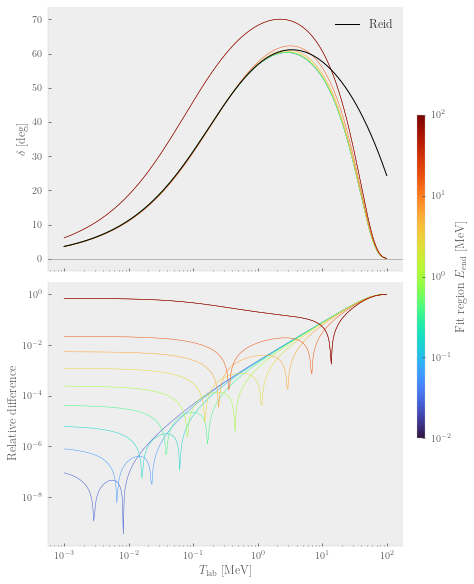

(PyObject[PyObject <AxesSubplot:ylabel='$\\delta$ [deg]'>, PyObject <AxesSubplot:xlabel='$T_{\\mathrm{lab}}$ [MeV]', ylabel='Relative difference'>], PyObject <matplotlib.colorbar.Colorbar object at 0x7fe21062bfd0>)

In [18]:
ax, cbar = plotfit(points, E, reid, VLOP, errpLOP)
#savefig(fig, "LOP_region_error.pdf")

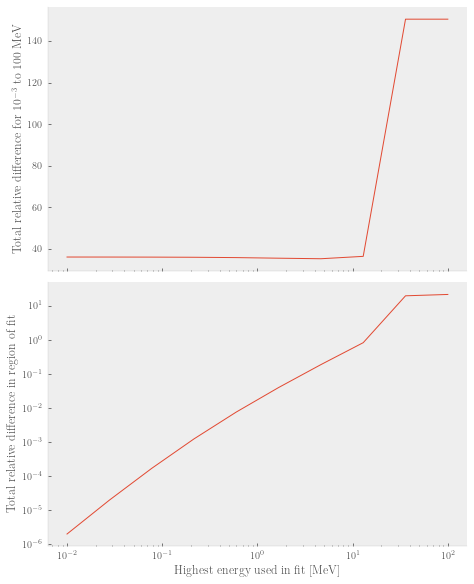

In [19]:
fig, ax = newfig(nrows=2, sharex=true, constrained_layout=true)
ax[1].plot(points, sum.(errpLOP))
ax[2].plot(points, errorsLOP)
ax[2].set_xlabel("Highest energy used in fit [MeV]")
ax[2].set_ylabel("Total relative difference in region of fit")
ax[1].set_ylabel(L"Total relative difference for $10^{-3}$ to $100$ MeV")
ax[2].set_yscale("log")
ax[2].set_xscale("log")
#savefig(fig, "LO_dependence_points_error.pdf")

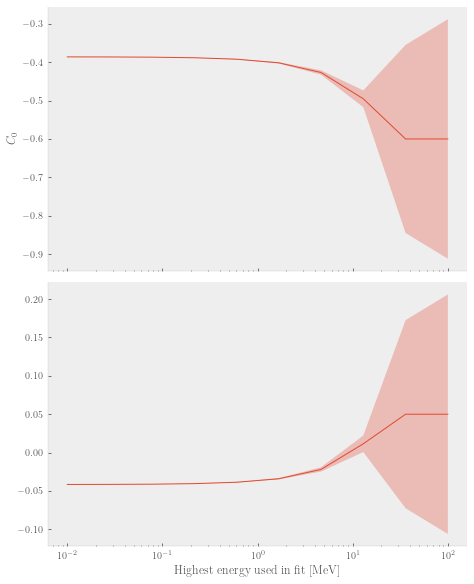

c0 = [fit.C[1] for fit = resLOP] = [-0.38611671377697504, -0.38632358718342363, -0.38688635343722677, -0.38836545642589365, -0.3921184886604899, -0.40162429479681144, -0.426762106952303, -0.4952996369419618, -0.6, -0.6]
vpi = [fit.C[2] for fit = resLOP] = [-0.04152568646910887, -0.04142708276764918, -0.04115873340835927, -0.040452719023831185, -0.03865747901526761, -0.03409317984423422, -0.021950533361100418, 0.011468719899143626, 0.05, 0.05]


PyObject Text(17.826775568181816, 0.5, '$C_0$')

In [20]:
fig, ax = newfig(nrows=2, sharex=true, constrained_layout=true)
@show c0 = [fit.C[1] for fit in resLOP]
@show vpi = [fit.C[2] for fit in resLOP]
c0ci_0, c0ci_1 = zip([confidence_interval(fit.res, 0.05)[1] for fit in resLOP]...)
vpici_0, vpici_1 = zip([confidence_interval(fit.res, 0.05)[2] for fit in resLOP]...)
ax[1].fill_between(points, c0ci_0, c0ci_1, alpha=0.3)
ax[1].plot(points, c0)
ax[2].fill_between(points, vpici_0, vpici_1, alpha=0.3)
ax[2].plot(points, vpi)
ax[2].set_xlabel("Highest energy used in fit [MeV]")
ax[2].set_xscale("log")
ax[1].set_ylabel(L"C_0")
#savefig(fig, "LO_coeff_dependence_region.pdf")

### NLO

In [21]:
points = 10 .^(range(log10(1e-2), log10(100), length=5))
resNLOP = measureregionpion(NLO, [-0.5, -0.0], [-0.005], points, 
    minlim=[-0.5, -0.05, -0.03], maxlim=[-0.1, 0.05, 0.05]);

100.0%┣████████████████████████████████████████████┫ 5/5 [03:37<00:00, 0.0 it/s]


In [24]:
for (point, res) in zip(points, resNLOP)
    @show point, res.C
end

(point, res.C) = (0.01, [-0.5, 0.05, -0.03])
(point, res.C) = (0.1, [-0.5, -0.05, -0.013340340530017493])
(point, res.C) = (1.0, [-0.1, -0.05, -0.03])
(point, res.C) = (10.0, [-0.1, -0.05, -0.03])
(point, res.C) = (100.0, [-0.1, -0.05, -0.03])


In [22]:
E, reid, VNLOP, errpNLOP, errorsNLOP = computeerrors(resNLOP, stop=1e2);

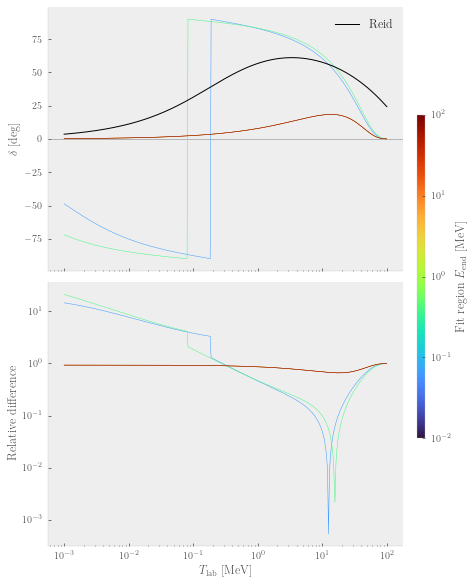

(PyObject[PyObject <AxesSubplot:ylabel='$\\delta$ [deg]'>, PyObject <AxesSubplot:xlabel='$T_{\\mathrm{lab}}$ [MeV]', ylabel='Relative difference'>], PyObject <matplotlib.colorbar.Colorbar object at 0x7fe210192f70>)

In [23]:
ax, cbar = plotfit(points, E, reid, VNLOP, errpNLOP)
#savefig(fig, "LOP_region_error.pdf")

In [ ]:
fig, ax = newfig(nrows=2, sharex=true, constrained_layout=true)
ax[1].plot(points, sum.(errpNLOP))
ax[2].plot(points, errorsNLOP)
ax[2].set_xlabel("Highest energy used in fit [MeV]")
ax[2].set_ylabel("Total relative difference in region of fit")
ax[1].set_ylabel(L"Total relative difference for $10^{-3}$ to $100$ MeV")
ax[2].set_yscale("log")
ax[2].set_xscale("log")
#savefig(fig, "LO_dependence_points_error.pdf")

In [ ]:
fig, ax = newfig(nrows=3, sharex=true, constrained_layout=true)
@show c0 = [fit.C[1] for fit in resNLOP]
@show c2 = [fit.C[2] for fit in resNLOP]
@show vpi = [fit.C[end] for fit in resNLOP]
c0ci_0, c0ci_1 = zip([confidence_interval(fit.res, 0.05)[1] for fit in resNLOP]...)
c2ci_0, c2ci_1 = zip([confidence_interval(fit.res, 0.05)[2] for fit in resNLOP]...)
vpici_0, vpici_1 = zip([confidence_interval(fit.res, 0.05)[end] for fit in resNLOP]...)
ax[1].fill_between(points, c0ci_0, c0ci_1, alpha=0.3)
ax[1].plot(points, c0)
ax[2].fill_between(points, c2ci_0, c2ci_1, alpha=0.3)
ax[2].plot(points, c2)
ax[end].fill_between(points, vpici_0, vpici_1, alpha=0.3)
ax[end].plot(points, vpi)
ax[end].set_xlabel("Highest energy used in fit [MeV]")
ax[end].set_xscale("log")
ax[1].set_ylabel(L"C_0")
ax[2].set_ylabel(L"C_2")
ax[end].set_ylabel(L"V_{\pi}")
#savefig(fig, "LO_coeff_dependence_region.pdf")

### NNLO

In [ ]:
E_fit, δReid_fit = computephase(Reid());
MSE(x, y) = mean((x.-y).^2)

function makeerrorfunctionpion(V; method::Scattering.Method=KMatrix(50), Λ=0.8)
    function error(coeffs)::Float64
        C = coeffs[1:end-1]
        Vπ = coeffs[end]
        W = regularize(V(C...) + Pion(Vπ), Λ)
        _, δ = computephase(W, method)
        MSE(δ, δReid_fit)
    end
    return error
end
makeerrorfunctionpion(V::Potential, m::Scattering.Method; kwargs...) = makeerrorfunctionpion(V; method=m, kwargs...)

Study the impact of $V_{\pi}$

In [ ]:
Vπs = -0.1:0.01:0.1
δs = []
for Vπ in Vπs
    V = regularize(LO(C0) + Pion(Vπ), 0.8)
    E, δ = rmatrix(V, endpoint=5)
    push!(δs, δ)
end

In [ ]:
fig, ax = plt.subplots()
cm = cmap("RdBu", length(Vπs))
E, δReid = rmatrix(Reid(), endpoint=5)
E, δLO = rmatrix(regularize(LO(C0), 0.8), endpoint=5)
E, δLO2 = rmatrix(regularize(LO(-0.53), 0.7), endpoint=5)

ax.plot(E, δReid, color="k", "-", label="Reid")
ax.plot(E, δLO2, color="k", "--", zorder=10, label="LO 0.7")
ax.plot(E, δLO, color="k", "-.", zorder=10, label="LO 0.8")
for i in 1:length(Vπs)
    ax.plot(E, δs[i], color=cm[i])
end
ax.set_ylim((0, 70))
ax.legend()
mpl = pyimport("matplotlib")
sm = plt.cm.ScalarMappable(cmap="RdBu", norm=mpl.colors.Normalize(vmin=minimum(Vπs), vmax=maximum(Vπs)))
plt.colorbar(sm, ax=ax, label=L"$V_{\pi}$") 

# Misc

### BlackBox

In [ ]:
using BlackBoxOptim

In [ ]:
V = NNLO
λ = 0.7
erf = makeerrorfunction(V, Λ=λ)
res = bboptimize(erf; SearchRange = [(-1.0, 1.0), (-1.0, 1.0), (-2.0, 1.0)],
        Method = :adaptive_de_rand_1_bin_radiuslimited, MaxTime = 3*60.0)

In [ ]:
@show bs = best_candidate(res)
@show bf = best_fitness(res)
E, reid = computephase(Reid(), endpoint=maxE, length=N)
E, nnlo = computephase(regularize(NNLO(bs...), 0.7), endpoint=maxE, length=N)

In [ ]:
fig, ax = newfig()
ax.plot(E, reid)
ax.plot(E, nnlo)
fig, ax = newfig()
ax.plot(E, relerr(reid, nnlo))
ax.set_xscale("log")
ax.set_yscale("log")

TODO:
- Name pionic interactions _pi
- Find region for LO, NLO, NNLO, ± pions
- Generalize procedure
- 1) Compare with/without pion

### Error

In [13]:
using Plots, Interact, Reactive

HTML{String}("<script>\n// Immediately-invoked-function-expression to avoid global variables.\n(function() {\n    var warning_div = document.getElementById(\"webio-warning-7841318869959367792\");\n    var hide = function () {\n        var script = document.getElementById(\"webio-setup-788805689756704518\");\n        var parent = script && script.parentElement;\n        var grandparent = parent && parent.parentElement;\n        if (grandparent) {\n            grandparent.style.display = \"none\";\n        }\n        warning_div.style.display = \"none\";\n    };\n    if (typeof Jupyter !== \"undefined\") {\n        console.log(\"WebIO detected Jupyter notebook environment.\");\n        // Jupyter notebook.\n        var extensions = (\n            Jupyter\n            && Jupyter.notebook.config.data\n            && Jupyter.notebook.config.data.load_extensions\n        );\n        if (extensions && extensions[\"webio-jupyter-notebook\"]) {\n            // Extension already loaded.\n            console.log(\"Jupyter WebIO nbextension detected; not loading ad-hoc.\");\n            hide();\n            return;\n        }\n    } else if (window.location.pathname.includes(\"/lab\")) {\n        // Guessing JupyterLa\n        console.log(\"Jupyter Lab detected; make sure the @webio/jupyter-lab-provider labextension is installed.\");\n        hide();\n        return;\n    }\n})();\n\n</script>\n<p\n    id=\"webio-warning-7841318869959367792\"\n    class=\"output_text output_stderr\"\n    style=\"padding: 1em; font-weight: bold;\"\n>\n    Unable to load WebIO. Please make sure WebIO works for your Jupyter client.\n    For troubleshooting, please see <a href=\"https://juliagizmos.github.io/WebIO.jl/latest/providers/ijulia/\">\n    the WebIO/IJulia documentation</a>.\n    <!-- TODO: link to installation docs. -->\n</p>\n")

In [14]:
function foo()
start = 1e-3
stop = 100
C0 = slider(-1.0:0.01:1.0, value=-0.5)
C2 = slider(-3.0:0.01:3.0, value=-0.03)
lambdas = slider(0.0:0.01:1.0, value=0.7)
Ns = slider(5:350, value=30, label="N")
lengths = slider(5:350, value=50)
mp = @manipulate throttle = 0.1 for C0s in C0, C2s in C2, lam in lambdas, N in Ns, length = slider(5:350, value=50)
    length=50
    method = KMatrix(N)
    V = regularize(NLO(C0s, C2s), lam)
    E = computerange(start, stop, length)
    k = .√(mass/197*E)
    δ = phaseshift(k, mass, V, method)
    plot(2E, δ)
end
end
foo()

Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Scope(Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :label), Any[nothing], Dict{Symbol,Any}(:className => "interact ",:style => Dict{Any,Any}(:padding => "5px 10px 0px 10px")))], Dict{Symbol,Any}(:className => "interact-flex-row-left")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :input), Any[], Dict{Symbol,Any}(:max => 201,:min => 1,:attributes => Dict{Any,Any}(:type => "range",Symbol("data-bind") => "numericValue: index, valueUpdate: 'input', event: {change: function (){this.changes(this.changes()+1)}}","orient" => "horizontal"),:step => 1,:className => "slider slider is-fullwidth",:style => Dict{Any,Any}()))], Dict{Symbol,Any}(:className => "interact-flex-row-center")), Node{WebIO.DOM}(WebIO.DOM(:html, :div), Any[Node{WebIO.DOM}(WebIO.DOM(:html, :p), Any[], Dict{Symbol,Any}(:attributes => Dict("data-bind" => "text: formatted_val")))], Dict{Symbol,Any}(:className => "interact-flex-row-right"))], Dict{Symbol,Any}(:className => "interact-flex-row interact-widget")), Dict{String,Tuple{Observables.AbstractObservable,Union{Nothing, Bool}}}("changes" => (Observable{Int64} with 1 listeners. Value:
0, nothing),"index" => (Observable{Any} with 2 listeners. Value:
51, nothing)), Set{String}(), nothing, Asset[Asset("js", "knockout", "/home/erdos/.julia/packages/Knockout/IP1uR/src/../assets/knockout.js"), Asset("js", "knockout_punches", "/home/erdos/.julia/packages/Knockout/IP1uR/src/../assets/knockout_punches.js"), Asset("js", nothing, "/home/erdos/.julia/packages/InteractBase/sOe2Z/src/../assets/all.js"), Asset("css", nothing, "/home/erdos/.julia/packages/InteractBase/sOe2Z/src/../assets/style.css"), Asset("css", nothing, "/home/erdos/.julia/packages/Interact/SbgIk/src/../assets/bulma_confined.min.css")], Dict{Any,Any}("changes" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"changes\"]()) ? (this.valueFromJulia[\"changes\"]=true, this.model[\"changes\"](val)) : undefined})")],"index" => Any[WebIO.JSString("(function (val){return (val!=this.model[\"index\"]()) ? (this.valueFromJulia[\"index\"]=true, this.model[\"index\"](val)) : undefined})")]), WebIO.ConnectionPool(Channel{Any}(sz_max:32,sz_curr:0), Set{AbstractConnection}(), Base.GenericCondition{Base.AlwaysLockedST}(Base.InvasiveLinkedList{Task}(Task (runnable) @0x00007f65dcddc760, Task (runnable) @0x00007f65dcddc760), Base.AlwaysLockedST(1))), WebIO.JSString[WebIO.JSString("function () {\n    var handler = (function (ko, koPunches) {\n    ko.punches.enableAll();\n    ko.bindingHandlers.numericValue = {\n        init: function(element, valueAccessor, allBindings, data, context) {\n            var stringified = ko.observable(ko.unwrap(valueAccessor()));\n            stringified.subscribe(function(value) {\n                var val = parseFloat(value);\n                if (!isNaN(val)) {\n                    valueAccessor()(val);\n                }\n            });\n            valueAccessor().subscribe(function(value) {\n                var str = JSON.stringify(value);\n                if ((str == \"0\") && ([\"-0\", \"-0.\"].indexOf(stringified()) >= 0))\n                     return;\n                 if ([\"null\", \"\"].indexOf(str) >= 0)\n                     return;\n                stringified(str);\n            });\n            ko.applyBindingsToNode(\n                element,\n                {\n                    value: stringified,\n                    valueUpdate: allBindings.get('valueUpdate'),\n                },\n                context,\n            );\n        }\n    };\n    var json_data = {\"formatted_vals\":[\"-1.0\",\"-0.99\",\"-0.98\",\"-0.97\",\"-0.96\",\"-0.95\",\"-0.94\",\"-0.93\",\"-0.92\",\"-0.91\",\"-0.9\",\"-0.89\",\"-0.88\",\"-0.87\",\"-0.86\",\"-0.85\",\"-0.84\",\"-0.83\",\"-0.82\",\"-0.81\",\"-0.8\",\"-0.79\",\"-0.78\",\"-0.77\",\"-0.76\",\"-

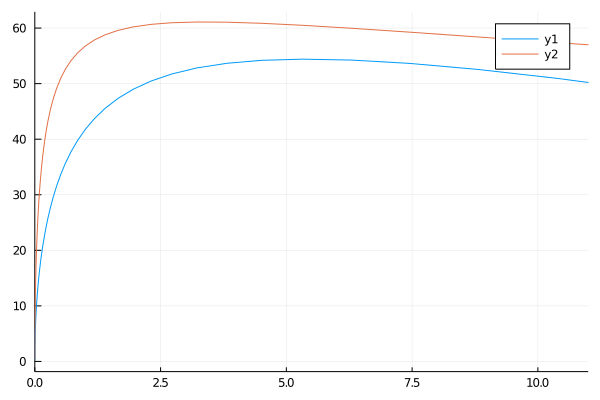

In [103]:
C0 = -0.4
C2 = -0.3
start = 1e-5
stop=150
lam=0.7
N = 30
len= 100
method = KMatrix(N)
V = regularize(NLO(C0, C2) + Pion(-0.003), lam)
E = computerange(start, stop, len) #range(start/2, stop/2, length=len)
k = .√(mass/197*E)
δ = phaseshift(k, mass, V, method)
plot(2E, δ)
δ = phaseshift(k, mass, Reid(), method)
plot!(2E, δ, xlim=(0, 11))

In [104]:
Pion(0.5)

Pion(0.7, 0.5)

In [105]:
@show k₀ = k[argmin(@. abs(2E-6))]
A, VV = createA(k₀, mass, 1000, V);

k₀ = k[argmin(#= In[105]:1 =# @__dot__(abs(2.0e-6)))] = 0.00034789511049247197


In [106]:
@show VV[end]
#heatmap(VV, color=:turbo, zscale=:log10)
#surface(VV , color=:turbo, zscale=:log10)

VV[end] = -0.40874642398388716


-0.40874642398388716

In [107]:
using LinearAlgebra

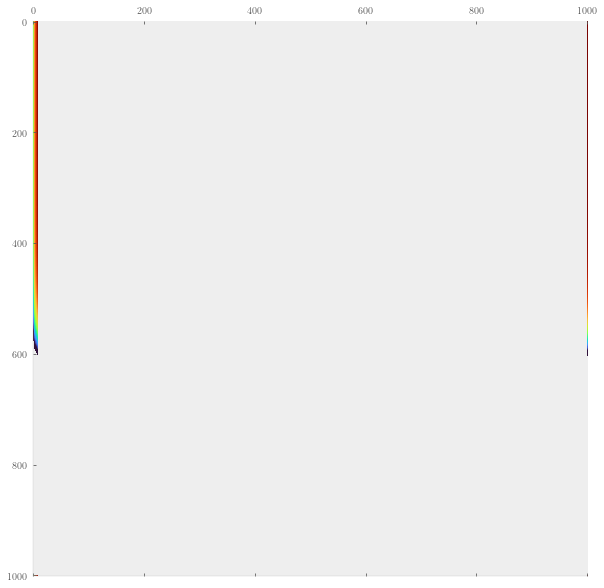

  0.091800 seconds (10 allocations: 15.291 MiB)


PyObject <matplotlib.image.AxesImage object at 0x7fb77ea03f70>

In [108]:
#heatmap(A, color=cgrad(:turbo))
#surface(A, color=:turbo)
@time S = A*A⁻¹ .- I(size(A)[1])
fig, ax = plt.subplots(figsize=(10, 10))
norm = plt.matplotlib.colors.LogNorm(vmin=minimum(S), vmax=maximum(S))
ax.matshow(S, cmap="turbo", norm=norm)

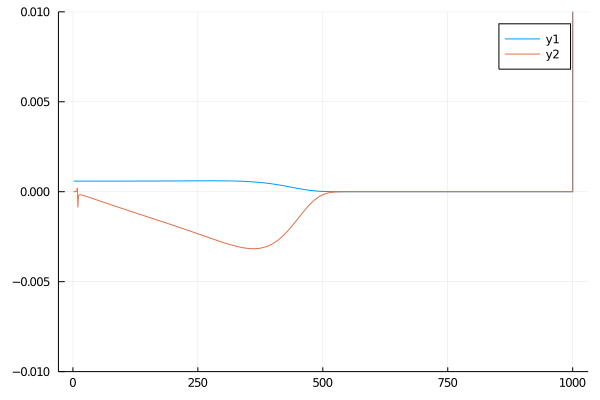

┌ Warning: /home/erdos/.julia/packages/Plots/hyS17/deps is not an existing directory, Revise is not watching
└ @ Revise /home/erdos/.julia/packages/Revise/34vmN/src/packagedef.jl:557
┌ Warning: /home/erdos/.julia/packages/Plots/hyS17/deps/SnoopCompile/precompile/linux/1.5 is not an existing directory, Revise is not watching
└ @ Revise /home/erdos/.julia/packages/Revise/34vmN/src/packagedef.jl:557
┌ Warning: /home/erdos/.julia/packages/PyCall/BcTLp/deps is not an existing directory, Revise is not watching
└ @ Revise /home/erdos/.julia/packages/Revise/34vmN/src/packagedef.jl:557
┌ Warning: /home/erdos/.julia/packages/Plots/hyS17/src/backends is not an existing directory, Revise is not watching
└ @ Revise /home/erdos/.julia/packages/Revise/34vmN/src/packagedef.jl:557
┌ Warning: /home/erdos/.julia/packages/SLEEFPirates/jGsib/src is not an existing directory, Revise is not watching
└ @ Revise /home/erdos/.julia/packages/Revise/34vmN/src/packagedef.jl:557
┌ Warning: /home/erdos/.julia/packag

In [109]:
plot(A[:, end], ylim=(-0.01, 0.01))
plot!(A[end, :])

In [75]:
A⁻¹ = inv(A);

In [76]:
#heatmap(A⁻¹ .|> symlog, color=cgrad(:turbo, scale=:log), zlim=())

In [77]:
K = A⁻¹*VV;
#heatmap(K, color=cgrad(:turbo, scale=:log), zscale=:log)
#heatmap(K, c=:turbo)

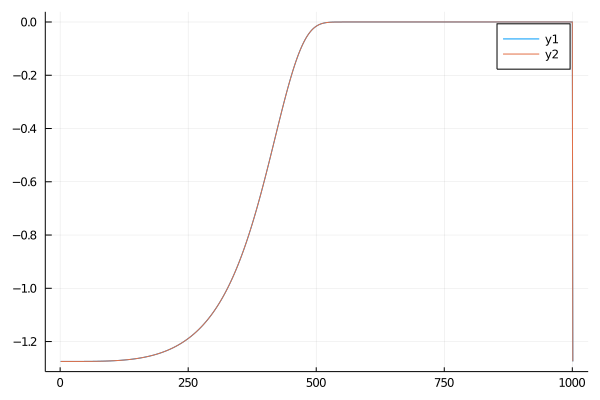

In [78]:
plot(VV[end, :])
plot!(VV[:, end])

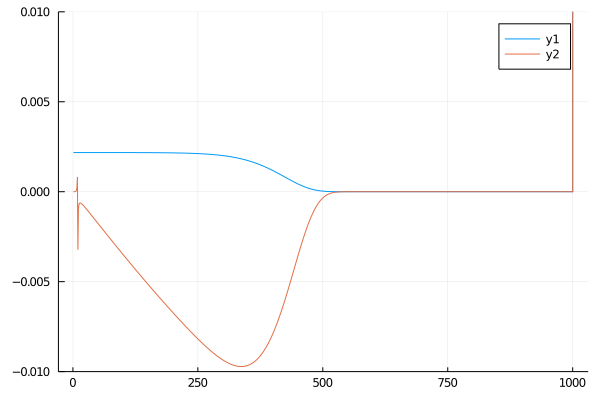

In [79]:
plot(A⁻¹[:, end], ylim=(-0.01, 0.01))
plot!(A⁻¹[end, :])

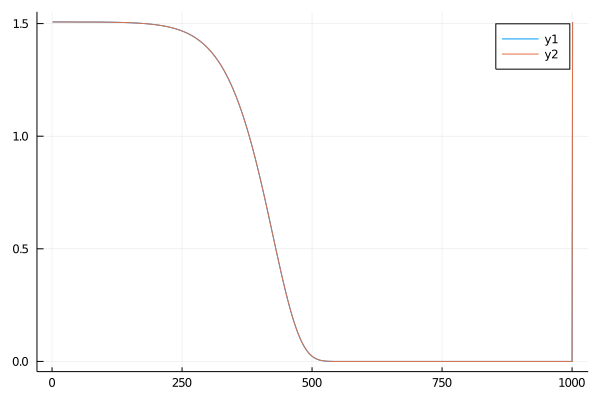

In [80]:
plot(K[end, :])
plot!(K[:, end])

In [81]:
@show Kk0 = K[end, end]
δᵢ = atan(-Kk0*mass*k₀) / pi * 180

Kk0 = K[end, end] = 1.5070616629643176


-0.14324977435309388

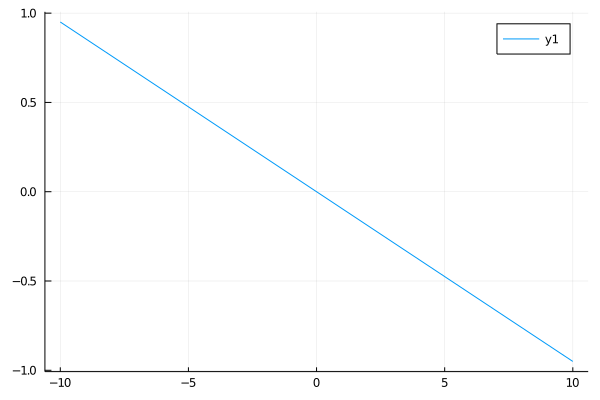

In [68]:
x = -10:0.1:10
plot(x, atan.(-x*mass*k₀)/pi*180)

In [27]:
function symlog(x)
    sign(x)*log10(sign(x)*x)
end

symlog (generic function with 1 method)

### Test

In [ ]:
int 0 inf dr r^2 j0(kr)V(x)j0(k'r)
int 0 inf inf dkdk' sin(kr)/kr

In [13]:
using HCubature

In [7]:
mass = 2*(mₙ*mₚ)/(mₙ+mₚ) /197  

4.768621711440031

In [245]:
function makefoo(r::Real)
    V = regularize(NLO(-0.54, 0.06) + Pion(0), 0.7)
    j0(k) = sin(k*r)/(k*r)
    function foo(x)
        k, k′ = x
        j0(k)*V(k, k′)*j0(k′)
    end
    foo
end

makefoo (generic function with 2 methods)

In [246]:
r = 1e-2:0.05:15
V = Float64[]
error = Float64[]
for r_ in r |> tqdm
    I, E = hcubature(makefoo(r_), [0, 0], [50, 50], maxevals=1000)
    push!(V, I)
    push!(error, E)
end

100.0%┣██████████████████████████████████████┫ 300/300 [00:01<00:00, 597.6 it/s]


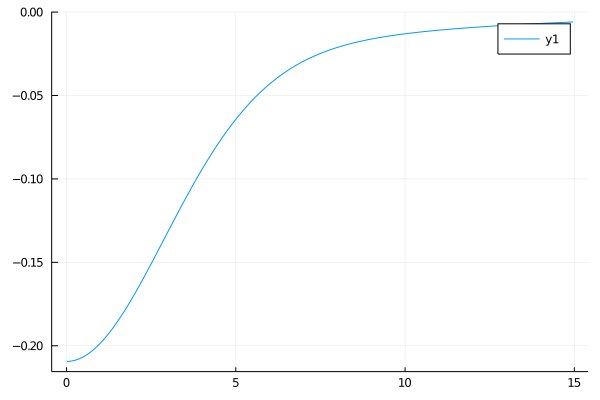

In [247]:
plot(r, V)#, ylim=(-1, 1))

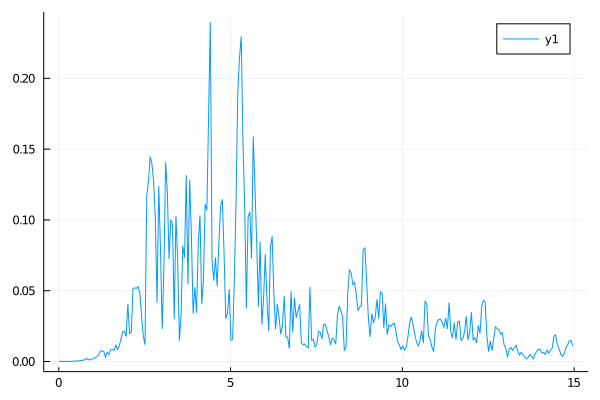

In [233]:
plot(r, error)

In [25]:
?hcubature

search: hcubature HCubature



```
hcubature(f, a, b; norm=norm, rtol=sqrt(eps), atol=0, maxevals=typemax(Int), initdiv=1)
```

Compute the n-dimensional integral of f(x), where `n == length(a) == length(b)`, over the hypercube whose corners are given by the vectors (or tuples) `a` and `b`. That is, dimension `x[i]` is integrated from `a[i]` to `b[i]`.  The return value of `hcubature` is a tuple `(I, E)` of the estimated integral `I` and an estimated error `E`.

`f` should be a function `f(x)` that takes an n-dimensional vector `x` and returns the integrand at `x`.   The integrand can be any type that supports `+`, `-`, `*` real, and `norm` functions.  For example, the integrand can be real or complex numbers, vectors, matrices, etcetera.

The integrand `f(x)` will be always be passed an `SVector{n,T}`, where `SVector` is an efficient vector type defined in the `StaticArrays` package and `T` is a floating-point type determined by promoting the endpoint `a` and `b` coordinates to a floating-point type. (Your integrand `f` should be type-stable: it should always return a value of the same type, given this type of `x`.)

The integrand will never be evaluated exactly at the boundaries of the integration volume.  (So, for example, it is possible to have an integrand that blows up at the boundaries, as long as the integral is finite, though such singularities will slow convergence.)

The integration volume is adaptively subdivided, using a cubature rule due to Genz and Malik (1980), until the estimated error `E` satisfies `E ≤ max(rtol*norm(I), atol)`, i.e. `rtol` and `atol` are the relative and absolute tolerances requested, respectively. It also stops if the number of `f` evaluations exceeds `maxevals`. If neither `atol` nor `rtol` are specified, the default `rtol` is the square root of the precision `eps(T)` of the coordinate type `T` described above. Initially, the volume is divided into `initdiv` segments along each dimension.

The error is estimated by `norm(I - I′)`, where `I′` is an alternative estimated integral (via an "embedded" lower-order cubature rule.) By default, the norm function used (for both this and the convergence test above) is `norm`, but you can pass an alternative norm by the `norm` keyword argument.  (This is especially useful when `f` returns a vector of integrands with different scalings.)
